## Import packages

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import numpy as np
from scipy import signal
import scipy.stats as sc
#import metpy as mtp
import math
from scipy import integrate
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from cartopy import feature as cfeat
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g
time_range = pd.date_range('1979-01-01', '2022-03-31 18:00:00', freq='6H')

### Load instantaneous AHT calcs

In [4]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series_full.nc')

In [5]:
def standardize(which_field):
    
    climatology_mean = which_field.groupby("time.weekofyear").mean("time")
    climatology_std = which_field.groupby("time.weekofyear").std("time")
    stand_anomalies = xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
        which_field.groupby("time.weekofyear"),
        climatology_mean,
        climatology_std,
    )

    return stand_anomalies

In [6]:
def running_sum(array, width=12):
    
    if width ==1:
        return array
    else:
        kernel = np.ones(width)
        running_sum = np.convolve(array,kernel)[:-width+1]

        for i in range(width-1):
            running_sum[i] += np.sum(array[-width+1+i:])

        return running_sum

In [7]:
def flatten(L):
    for item in L:
        try:
            yield from flatten(item)
        except TypeError:
            yield item

# Now let's see how big the event was zonally-integrated

/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/xarray/core/accessor_dt.py:380: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/xarray/core/accessor_dt.py:380: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


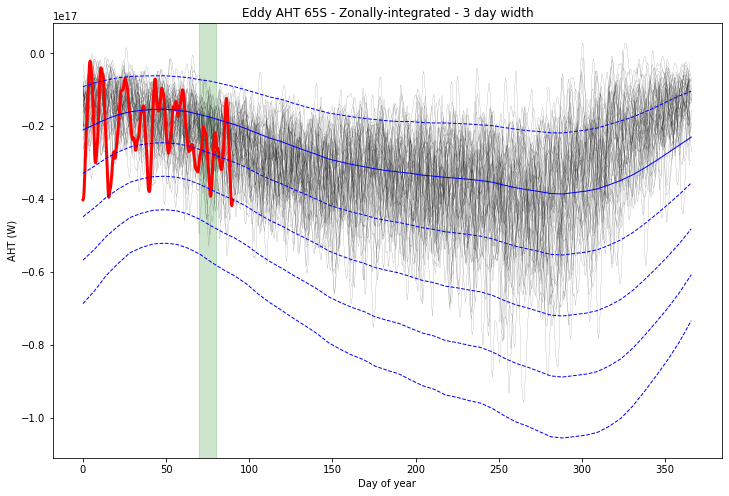

In [8]:
%matplotlib inline

plt.figure(figsize=(12,8))

groups = range(1979, 2023)

which_width=12

which_field = aht_ds.eddy_aht.sel(latitude=-65)

mean_aht = which_field.groupby('time.weekofyear').mean('time')
std_aht = which_field.groupby('time.weekofyear').std('time')

running_sum_values = []
annual_maxs = []

#year_grouped = standardize(which_field).groupby('time.year')
year_grouped = which_field.groupby('time.year')
for group in groups:

    one_year = year_grouped[group]
    
    one_year_running_sum = running_sum(one_year.values, width=which_width)
    
    annual_maxs.append(np.min(one_year_running_sum))
    
    running_sum_values.append(one_year_running_sum)
    plot_color = 'k' if group != 2022 else 'r'
    line_width = .1 if group != 2022 else 3
    #plt.plot(range(len(one_year)), one_year, color=plot_color, linewidth=line_width)
    plt.plot(np.linspace(0, len(one_year_running_sum)//4, len(one_year_running_sum)), one_year_running_sum,
             color=plot_color, linewidth=line_width)


plt.plot(np.linspace(0, len(mean_aht)*6.9, len(mean_aht)), running_sum(mean_aht, width=which_width), color='b', linewidth=1)

for i in range(1,5):
    plt.plot(np.linspace(0, len(mean_aht)*6.9, len(mean_aht)), running_sum(mean_aht - i*std_aht, width=which_width),
             '--', color='b', linewidth=1)
plt.plot(np.linspace(0, len(mean_aht)*6.9, len(mean_aht)), running_sum(mean_aht + std_aht, width=which_width),
         '--', color='b', linewidth=1)

plt.axvspan(70, 80, color='green', alpha=0.2)


plt.xlabel('Day of year')
plt.ylabel('AHT (W)')

plt.title('Eddy AHT 65S - Zonally-integrated - 3 day width')

#plt.savefig('figures/4_20_22_meeting/zonally_integrated_eddy_moist_aht_65s_3day_width')
#plt.savefig('figures/4_20_22_meeting/zonally_integrated_eddy_aht_65s_3day_width.eps', format='eps')

plt.show()

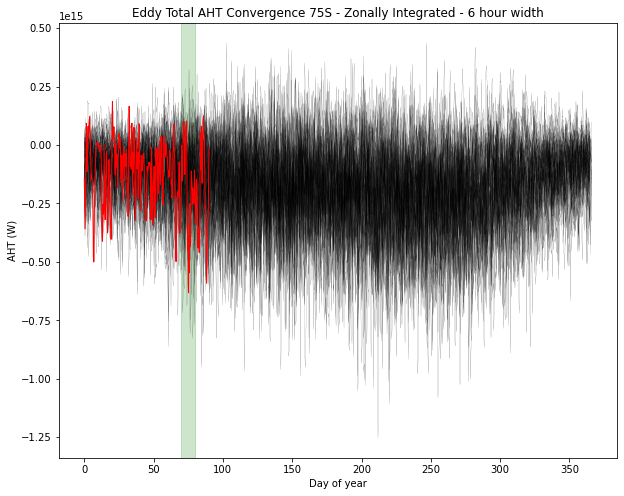

In [9]:
groups = range(1979, 2023)

plt.figure(figsize=(10, 8))
which_field = aht_ds.eddy_aht.differentiate('latitude').sel(latitude=-70)
#year_grouped = standardize(which_field).groupby('time.year')
year_grouped = which_field.groupby('time.year')
for group in groups:

    one_year = year_grouped[group]
    
    plot_color = 'k' if group != 2022 else 'r'
    line_width = .1 if group != 2022 else 1
    plt.plot(np.linspace(0, len(one_year) // 4, len(one_year)), running_sum(one_year, width=1), color=plot_color, linewidth=line_width)

plt.axvspan(70, 80, color='green', alpha=0.2)

plt.xlabel('Day of year')
plt.ylabel('AHT (W)')

plt.title('Eddy Total AHT Convergence 75S - Zonally Integrated - 6 hour width')

#plt.savefig('figures/4_20_22_meeting/zonally_integrated_eddy_total_aht_75s_6hr_width')

plt.show()

### Now lets look at this sectorally

In [8]:
aht_ds_65 = xr.open_dataset('../aht_time_series/era5_eddy_aht_time_series_-65deg.nc')
aht_ds_75 = xr.open_dataset('../aht_time_series/era5_eddy_aht_time_series_-75deg.nc')

In [10]:
lon_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]
lon_bin_labels = ['0_45', '45_90', '90_135', '135_180', '180_225', '225_270',
                  '270_315', '315_360']

sector_means_65 = aht_ds_65.groupby_bins('longitude', lon_bins, labels=lon_bin_labels).mean(['longitude'])
sector_means_75 = aht_ds_75.groupby_bins('longitude', lon_bins, labels=lon_bin_labels).mean(['longitude'])



/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/xarray/core/accessor_dt.py:380: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/xarray/core/accessor_dt.py:380: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


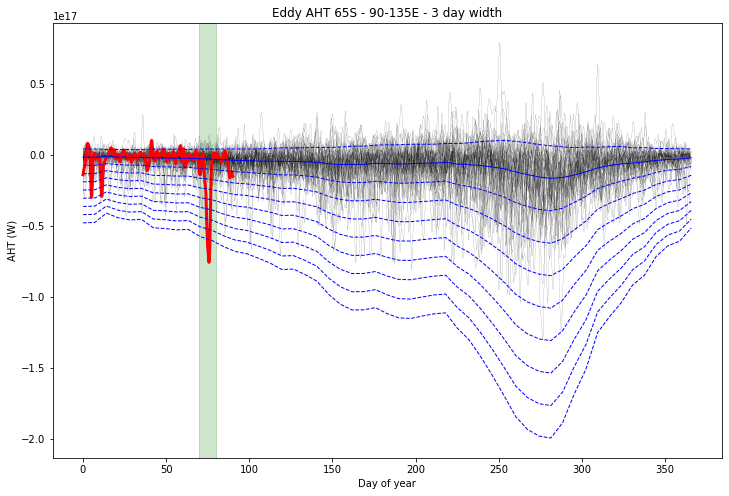

In [11]:
%matplotlib inline

plt.figure(figsize=(12,8))

groups = range(1979, 2023)

which_width=4

which_field = sector_means_65.eddy_aht.sel(longitude_bins='90_135')

mean_aht = which_field.groupby('time.weekofyear').mean('time')
std_aht = which_field.groupby('time.weekofyear').std('time')

running_sum_values = []
annual_maxs = []

#year_grouped = standardize(which_field).groupby('time.year')
year_grouped = which_field.groupby('time.year')
for group in groups:

    one_year = year_grouped[group]
    
    one_year_running_sum = running_sum(one_year.values, width=which_width)
    
    annual_maxs.append(np.min(one_year_running_sum))
    
    running_sum_values.append(one_year_running_sum)
    plot_color = 'k' if group != 2022 else 'r'
    line_width = .1 if group != 2022 else 3
    #plt.plot(range(len(one_year)), one_year, color=plot_color, linewidth=line_width)
    plt.plot(np.linspace(0, len(one_year_running_sum)//4, len(one_year_running_sum)), one_year_running_sum,
             color=plot_color, linewidth=line_width)


plt.plot(np.linspace(0, len(mean_aht)*6.9, len(mean_aht)), running_sum(mean_aht, width=which_width), color='b', linewidth=1)

for i in range(1,9):
    plt.plot(np.linspace(0, len(mean_aht)*6.9, len(mean_aht)), running_sum(mean_aht - i*std_aht, width=which_width),
             '--', color='b', linewidth=1)
plt.plot(np.linspace(0, len(mean_aht)*6.9, len(mean_aht)), running_sum(mean_aht + std_aht, width=which_width),
         '--', color='b', linewidth=1)

plt.axvspan(70, 80, color='green', alpha=0.2)


plt.xlabel('Day of year')
plt.ylabel('AHT (W)')

plt.title('Eddy AHT 65S - 90-135E - 3 day width')

#plt.savefig('figures/4_20_22_meeting/90_135e_eddy_aht_moist_65s_3day_width')
#plt.savefig('figures/4_20_22_meeting/90_135e_eddy_aht_65s_3day_width.eps', format='eps')

plt.show()

In [16]:
full_year_data

<xarray.Dataset>
Dimensions:                    (time: 124)
Coordinates:
    longitude_bins             <U6 '90_135'
  * time                       (time) datetime64[ns] 2022-03-01 ... 2022-03-3...
Data variables:
    eddy_aht                   (time) float64 -4.276e+14 ... -2.888e+14
    eddy_aht_moist             (time) float64 -1.188e+14 ... -6.355e+13
    eddy_aht_dry               (time) float64 -3.088e+14 ... -2.253e+14
    eddy_aht_no_seasons        (time) float64 -3.801e+14 ... -2.593e+14
    eddy_aht_no_seasons_moist  (time) float64 -9.289e+13 ... -4.334e+13
    eddy_aht_no_seasons_dry    (time) float64 -2.872e+14 ... -2.16e+14

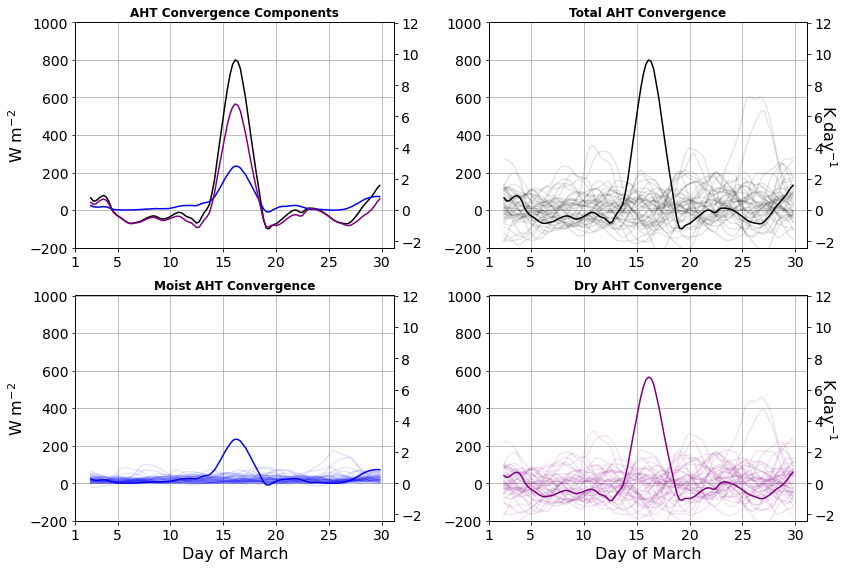

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))

years = range(1979, 2023)

for year in years:

    year_data_65 = sector_means_65.sel(longitude_bins='90_135').sel(time=slice(f'{year}-03-01', f'{year}-03-31'))
    year_data_75 = sector_means_75.sel(longitude_bins='90_135').sel(time=slice(f'{year}-03-01', f'{year}-03-31'))
    
    #full_year_data = ((year_data_65 + year_data_75) / 2).rolling(time=12, center=True).mean()
    full_year_data = ((year_data_65 - year_data_75) / 10).rolling(time=12, center=True).mean()
    #full_year_data = year_data_65
    
    full_year_data = -full_year_data / (111111 * 2 * np.pi * a * np.cos(np.deg2rad(70)))
    if year == 2022:
        color_tot='k'
        alpha_tot=1
        
        color_moist = 'b'
        alpha_moist = 1
        
        color_dry = 'purple'
        alpha_dry = 1
        
        axs[0,0].plot(np.linspace(1, 31, 124), full_year_data.eddy_aht,
                  color=color_tot, alpha=alpha_tot)
        axs[0,0].plot(np.linspace(1, 31, 124), full_year_data.eddy_aht_moist,
                      color=color_moist, alpha=alpha_moist)

        axs[0,0].plot(np.linspace(1, 31, 124), full_year_data.eddy_aht_dry,
                      color=color_dry, alpha=alpha_dry)
    
    else:
        color_tot='k'
        alpha_tot=0.1
        
        color_moist = 'b'
        alpha_moist = 0.1
        
        color_dry = 'purple'
        alpha_dry = 0.1
        
    
    axs[0,1].plot(np.linspace(1, 31, 124), full_year_data.eddy_aht,
                  color=color_tot, alpha=alpha_tot)
    axs[1,0].plot(np.linspace(1, 31, 124), full_year_data.eddy_aht_moist,
                  color=color_moist, alpha=alpha_moist)
    
    axs[1,1].plot(np.linspace(1, 31, 124), full_year_data.eddy_aht_dry,
                  color=color_dry, alpha=alpha_dry)
    
    
axs[0,0].grid()
axs[1,0].grid()
axs[0,1].grid()
axs[1,1].grid()

axs[0,0].set_title('AHT Convergence Components', fontweight='semibold')
axs[0,1].set_title('Total AHT Convergence', fontweight='semibold')
axs[1,0].set_title('Moist AHT Convergence', fontweight='semibold')
axs[1,1].set_title('Dry AHT Convergence', fontweight='semibold')

#y_lims = [-0.15e16, 0.1e16]
ylim1 = -200
ylim2 = 1000
y_lims = [ylim1, ylim2]
axs[0,0].set_ylim(y_lims)
axs[1,0].set_ylim(y_lims)
axs[0,1].set_ylim(y_lims)
axs[1,1].set_ylim(y_lims)

axis_conv = (3600 * 24 * g) / (cp * 70000)
axs002 = axs[0,0].twinx()
axs002.set_ylim([ylim1 * axis_conv, ylim2 * axis_conv])
axs002.tick_params(axis='y', which='major', labelsize=14)
axs102 = axs[1,0].twinx()
axs102.set_ylim([ylim1 * axis_conv, ylim2 * axis_conv])
axs102.tick_params(axis='y', which='major', labelsize=14)
axs012 = axs[0,1].twinx()
axs012.set_ylim([ylim1 * axis_conv, ylim2 * axis_conv])
axs012.tick_params(axis='y', which='major', labelsize=14)
axs112 = axs[1,1].twinx()
axs112.set_ylim([ylim1 * axis_conv, ylim2 * axis_conv])
axs112.tick_params(axis='y', which='major', labelsize=14)

axs[0,0].set_ylabel('W $\mathregular{m^{-2}}$', fontsize=16)
axs[1,0].set_ylabel('W $\mathregular{m^{-2}}$', fontsize=16)
axs012.set_ylabel('K $\mathregular{day^{-1}}$', fontsize=16, rotation=270)
axs112.set_ylabel('K $\mathregular{day^{-1}}$', fontsize=16, rotation=270)
axs[1,0].set_xlabel('Day of March', fontsize=16)
axs[1,1].set_xlabel('Day of March', fontsize=16)

axs[0,0].set_xticks([1, 5, 10, 15, 20, 25, 30])
axs[1,0].set_xticks([1, 5, 10, 15, 20, 25, 30])
axs[0,1].set_xticks([1, 5, 10, 15, 20, 25, 30])
axs[1,1].set_xticks([1, 5, 10, 15, 20, 25, 30])

axs[0,0].tick_params(axis='both', which='major', labelsize=14)
axs[1,0].tick_params(axis='both', which='major', labelsize=14)
axs[0,1].tick_params(axis='both', which='major', labelsize=14)
axs[1,1].tick_params(axis='both', which='major', labelsize=14)

#plt.suptitle('Antarctic AHT in March', fontsize=15)

fig.tight_layout()
#plt.legend(loc=0)

plt.savefig('aht_convergence_dome_c')
plt.show()

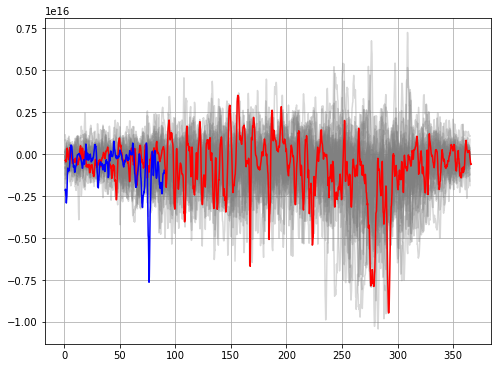

In [109]:
which_field = sector_means_75.eddy_aht.sel(longitude_bins='90_135')

which_field_grouped = which_field.groupby('time.year')

plt.figure(figsize=(8,6))

for year in range(1979, 2022):
    
    plot_field = which_field_grouped[year]
    
    plot_color = 'grey'
    
    #if year == 1992:
        #plot_color='r'
    #elif year == 2022:
        #plot_color='b'
    plt.plot(np.linspace(1, 365, len(plot_field)), plot_field, color=plot_color, alpha=0.3)

plt.plot(np.linspace(1, len(which_field_grouped[1992]) / 4, len(which_field_grouped[1992])), which_field_grouped[1992], color='r')
plt.plot(np.linspace(1, len(which_field_grouped[2022]) / 4, len(which_field_grouped[2022])), which_field_grouped[2022], color='b')

plt.grid()
plt.show()

In [110]:
print(np.sort(which_field_grouped[2022].sel(time=which_field_grouped[2022].time.dt.month.isin(3)).fillna(0).values)[:10])

print(np.sort(which_field_grouped[1992].sel(time=which_field_grouped[1992].time.dt.month.isin(6)).fillna(0).values)[:10])


[-7.63470551e+15 -7.32486327e+15 -6.19042761e+15 -5.85548884e+15
 -5.02703171e+15 -4.83746540e+15 -4.09073073e+15 -3.52127454e+15
 -3.44076941e+15 -3.17528423e+15]
[-6.68047004e+15 -6.42997209e+15 -5.15050604e+15 -3.72562004e+15
 -2.75126098e+15 -1.86434559e+15 -1.83319955e+15 -1.64295678e+15
 -1.58998453e+15 -1.42735419e+15]


In [111]:
print(np.sort(which_field_grouped[2022].sel(time=which_field_grouped[2022].time.dt.month.isin(3)).rolling(time=12).mean('time').fillna(0).values)[:10])

print(np.sort(which_field_grouped[1992].sel(time=which_field_grouped[1992].time.dt.month.isin(6)).rolling(time=12).mean('time').fillna(0).values)[:10])


[-4.65375375e+15 -4.57534325e+15 -4.57408186e+15 -4.36322404e+15
 -4.32129516e+15 -4.01478573e+15 -3.99697864e+15 -3.62935409e+15
 -3.60195152e+15 -3.11976411e+15]
[-2.45205865e+15 -2.43041227e+15 -2.30283318e+15 -2.26375982e+15
 -2.17527612e+15 -2.08506090e+15 -1.97220546e+15 -1.86552989e+15
 -1.78892578e+15 -1.51055649e+15]


In [103]:
which_field_grouped[2022].sel(time=which_field_grouped[2022].time.dt.month.isin(3))

<xarray.DataArray 'eddy_aht' (time: 124)>
array([ 1.40509767e+14,  7.40880018e+13, -1.92956306e+13,  8.09889542e+13,
        5.59113509e+13,  2.20077149e+13, -4.23559903e+13,  1.44457344e+14,
        5.03772152e+14,  6.66687235e+14,  5.20200076e+14,  4.45454338e+14,
        2.88533823e+14,  6.47271296e+12, -4.64936897e+14, -8.41040133e+14,
       -1.14779296e+15, -1.20118268e+15, -1.59263354e+15, -1.81451871e+15,
       -1.97494131e+15, -1.88159873e+15, -1.93897398e+15, -1.68458856e+15,
       -1.50771521e+15, -1.27115098e+15, -1.24676513e+15, -1.04473530e+15,
       -9.48665390e+14, -8.10273051e+14, -6.18587832e+14, -2.34227690e+14,
       -2.01429467e+13,  2.50613811e+13, -5.86847092e+13, -1.49773989e+14,
       -4.61415905e+14, -7.19604216e+14, -1.32097221e+15, -1.47294231e+15,
       -1.78139868e+15, -2.18776483e+15, -2.90529831e+15, -2.96568613e+15,
       -3.17528423e+15, -2.96220436e+15, -2.75893532e+15, -2.45779501e+15,
       -2.45189004e+15, -2.22339707e+15, -2.29493708e+15, -2.06006282e+15,
       -1.89330945e+15, -1.44061072e+15, -9.91148936e+14, -5.46888822e+14,
       -2.60449977e+13,  4.62673861e+14,  6.67880132e+14,  6.49594782e+14,
        4.51028721e+14, -1.12104432e+14, -1.36847813e+15, -2.45220227e+15,
       -3.52127454e+15, -4.83746540e+15, -5.02703171e+15, -6.19042761e+15,
       -7.63470551e+15, -7.32486327e+15, -5.85548884e+15, -4.09073073e+15,
       -3.44076941e+15, -3.14554487e+15, -2.32454079e+15, -1.51127635e+15,
       -9.75844014e+14, -6.56205673e+14, -4.01852004e+14, -7.53479101e+13,
        1.77730502e+14, -7.42505981e+13, -5.97319449e+14, -1.23253599e+15,
       -1.27235230e+15, -1.03070267e+15, -2.14732662e+14,  3.19828795e+13,
        1.52426555e+14,  2.22533119e+14,  8.78563438e+13, -2.73561895e+14,
       -8.42226470e+14, -1.15452133e+15, -1.37997318e+15, -1.43528857e+15,
       -1.38254288e+15, -1.28912749e+15, -8.73656305e+14, -5.76919955e+14,
       -4.58174828e+14, -4.55113660e+14, -6.03659955e+14, -7.44374818e+14,
       -1.16174947e+15, -1.58499827e+15, -1.82665990e+15, -1.81655277e+15,
       -2.02861620e+15, -1.92413854e+15, -1.87331352e+15, -1.68152552e+15,
       -1.86610547e+15, -2.07523323e+15, -2.32305479e+15, -2.35959066e+15,
       -2.00982373e+15, -1.72115738e+15, -1.35938986e+15, -1.16405269e+15,
       -1.15862418e+15, -1.09713168e+15, -1.14129517e+15, -9.63350760e+14])
Coordinates:
    longitude_bins  <U6 '90_135'
  * time            (time) datetime64[ns] 2022-03-01 ... 2022-03-31T18:00:00

In [102]:
which_field_grouped[2022].time.dt.month

<xarray.DataArray 'month' (time: 360)>
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])
Coordinates:
    longitude_bins  <U6 '90_135'
  * time            (time) datetime64[ns] 2022-01-01 ... 2022-03-31T18:00:00

In [16]:
running_sum_flat = np.array(list(flatten(running_sum_values)))

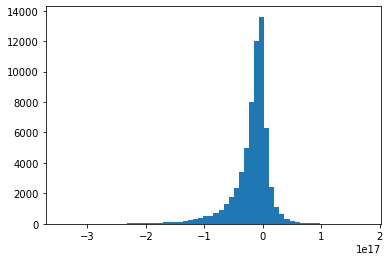

In [17]:
plt.hist(running_sum_flat, bins=60)
plt.show()

In [18]:
idx = np.argpartition(running_sum_flat, 5)

values = (running_sum_flat[idx[:5]])

In [19]:
print(idx[:15])
print(values)

[62470 62471 62472 62469 62473 30373 30374 30372 30376 30377 20101 41977
 41976 41975 15747]
[-3.44673318e+17 -3.42499176e+17 -3.30852515e+17 -3.30722020e+17
 -3.14810408e+17]


In [20]:
print(time_range[idx][:15])
print(running_sum_flat[idx][:15])

DatetimeIndex(['2021-10-04 12:00:00', '2021-10-04 18:00:00',
               '2021-10-05 00:00:00', '2021-10-04 06:00:00',
               '2021-10-05 06:00:00', '1999-10-16 06:00:00',
               '1999-10-16 12:00:00', '1999-10-16 00:00:00',
               '1999-10-17 00:00:00', '1999-10-17 06:00:00',
               '1992-10-04 06:00:00', '2007-09-25 06:00:00',
               '2007-09-25 00:00:00', '2007-09-24 18:00:00',
               '1989-10-11 18:00:00'],
              dtype='datetime64[ns]', freq=None)
[-3.44673318e+17 -3.42499176e+17 -3.30852515e+17 -3.30722020e+17
 -3.14810408e+17 -3.09803592e+17 -3.09377011e+17 -3.08001618e+17
 -3.01014516e+17 -2.92087467e+17 -2.34901235e+17 -2.42595676e+17
 -2.38014867e+17 -2.32233480e+17 -2.32042114e+17]


In [21]:
# 2 day
2.636 / 2.585

1.0197292069632495

In [22]:
#3 day
3.484 / 2.396

1.4540901502504173

In [23]:
#4 day
3.916 / 3.275

1.1957251908396946

### Now let's look at 74-76S

In [117]:
aht_ds_74 = xr.open_dataset('../aht_time_series/era5_eddy_aht_time_series_-74deg.nc')
aht_ds_75 = xr.open_dataset('../aht_time_series/era5_eddy_aht_time_series_-75deg.nc')
aht_ds_76 = xr.open_dataset('../aht_time_series/era5_eddy_aht_time_series_-76deg.nc')

In [118]:
aht_ds_75

<xarray.Dataset>
Dimensions:              (time: 63184, longitude: 720)
Coordinates:
  * time                 (time) datetime64[ns] 1979-01-01 ... 1979-01-01
  * longitude            (longitude) float64 0.0 0.5 1.0 ... 358.5 359.0 359.5
Data variables:
    eddy_aht             (time, longitude) float64 ...
    eddy_aht_no_seasons  (time, longitude) float64 ...
Attributes:
    description:  AHT data at -75deg

In [108]:
aht_ds_local_full = xr.concat([aht_ds_74, aht_ds_75, aht_ds_76], pd.Index([-74, -75, -76], name='latitude'))

In [112]:
lon_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]
lon_bin_labels = ['0_45', '45_90', '90_135', '135_180', '180_225', '225_270',
                  '270_315', '315_360']

sector_means_75 = aht_ds_local_full.groupby_bins('longitude', lon_bins, labels=lon_bin_labels).mean(['longitude'])

/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/xarray/core/accessor_dt.py:380: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/xarray/core/accessor_dt.py:380: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


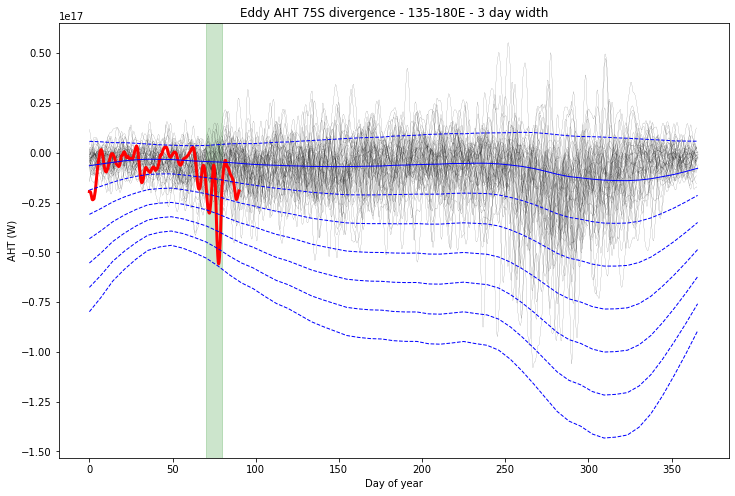

In [113]:
%matplotlib inline

plt.figure(figsize=(12,8))

groups = range(1979, 2023)

which_width=12

#which_field = sector_means_75.eddy_aht.sel(longitude_bins='135_180').differentiate('latitude').sel(latitude=-75)
which_field = sector_means_75.eddy_aht.sel(longitude_bins='90_135').sel(latitude=-75)

mean_aht = which_field.groupby('time.weekofyear').mean('time')
std_aht = which_field.groupby('time.weekofyear').std('time')

running_sum_values = []
annual_maxs = []

#year_grouped = standardize(which_field).groupby('time.year')
year_grouped = which_field.groupby('time.year')
for group in groups:

    one_year = year_grouped[group]
    
    one_year_running_sum = running_sum(one_year.values, width=which_width)
    
    annual_maxs.append(np.min(one_year_running_sum))
    
    running_sum_values.append(one_year_running_sum)
    plot_color = 'k' if group != 2022 else 'r'
    line_width = .1 if group != 2022 else 3
    #plt.plot(range(len(one_year)), one_year, color=plot_color, linewidth=line_width)
    plt.plot(np.linspace(0, len(one_year_running_sum)//4, len(one_year_running_sum)), one_year_running_sum,
             color=plot_color, linewidth=line_width)


plt.plot(np.linspace(0, len(mean_aht)*6.9, len(mean_aht)), running_sum(mean_aht, width=which_width), color='b', linewidth=1)

for i in range(1,7):
    plt.plot(np.linspace(0, len(mean_aht)*6.9, len(mean_aht)), running_sum(mean_aht - i*std_aht, width=which_width),
             '--', color='b', linewidth=1)
plt.plot(np.linspace(0, len(mean_aht)*6.9, len(mean_aht)), running_sum(mean_aht + std_aht, width=which_width),
         '--', color='b', linewidth=1)

plt.axvspan(70, 80, color='green', alpha=0.2)


plt.xlabel('Day of year')
plt.ylabel('AHT (W)')

plt.title('Eddy AHT 75S divergence - 135-180E - 3 day width')

#plt.savefig('figures/4_20_22_meeting/135_180e_eddy_aht_divergence_75s_3day_width')

plt.show()

### Let's look at just 550hPa

In [28]:
aht_ds_local_550 = xr.open_dataset('aht_time_series/era5_eddy_aht_time_series_-75deg550hPa.nc')

In [29]:
lon_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]
lon_bin_labels = ['0_45', '45_90', '90_135', '135_180', '180_225', '225_270',
                  '270_315', '315_360']

sector_means_550 = aht_ds_local_550.groupby_bins('longitude', lon_bins, labels=lon_bin_labels).mean(['longitude'])


/tdat/tylersc/mini3/envs/jupyter_copy/lib/python3.9/site-packages/xarray/core/accessor_dt.py:380: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/tdat/tylersc/mini3/envs/jupyter_copy/lib/python3.9/site-packages/xarray/core/accessor_dt.py:380: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


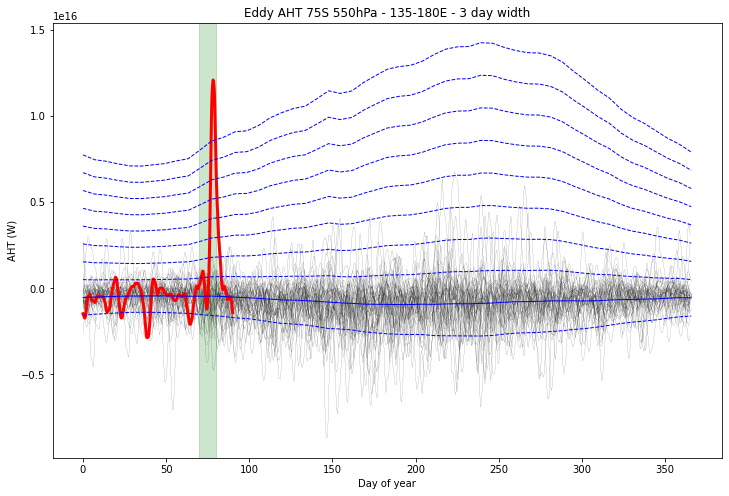

In [30]:
%matplotlib inline

plt.figure(figsize=(12,8))

groups = range(1979, 2023)

which_width=12

which_field = sector_means_550.eddy_aht.sel(longitude_bins='135_180')

mean_aht = which_field.groupby('time.weekofyear').mean('time')
std_aht = which_field.groupby('time.weekofyear').std('time')

running_sum_values = []
annual_maxs = []

#year_grouped = standardize(which_field).groupby('time.year')
year_grouped = which_field.groupby('time.year')
for group in groups:

    one_year = year_grouped[group]
    
    one_year_running_sum = running_sum(one_year.values, width=which_width)
    
    annual_maxs.append(np.min(one_year_running_sum))
    
    running_sum_values.append(one_year_running_sum)
    plot_color = 'k' if group != 2022 else 'r'
    line_width = .1 if group != 2022 else 3
    #plt.plot(range(len(one_year)), one_year, color=plot_color, linewidth=line_width)
    plt.plot(np.linspace(0, len(one_year_running_sum)//4, len(one_year_running_sum)), one_year_running_sum,
             color=plot_color, linewidth=line_width)


plt.plot(np.linspace(0, len(mean_aht)*6.9, len(mean_aht)), running_sum(mean_aht, width=which_width), color='b', linewidth=1)

for i in range(1,9):
    plt.plot(np.linspace(0, len(mean_aht)*6.9, len(mean_aht)), running_sum(mean_aht + i*std_aht, width=which_width),
             '--', color='b', linewidth=1)
plt.plot(np.linspace(0, len(mean_aht)*6.9, len(mean_aht)), running_sum(mean_aht - std_aht, width=which_width),
         '--', color='b', linewidth=1)

plt.axvspan(70, 80, color='green', alpha=0.2)


plt.xlabel('Day of year')
plt.ylabel('AHT (W)')

plt.title('Eddy AHT 75S 550hPa - 135-180E - 3 day width')

#plt.savefig('figures/4_20_22_meeting/135-180e_eddy_aht_550hPa_75s_3day_width')

plt.show()

### Let's look at the vertical structure of the event now

In [14]:
#All AHT values are at 75S at one longitude verically summed
times = np.arange(63100, 63160, 1) #March 2022 event ~ 6.7e10 AHT
#times = np.arange(5100, 5160, 1) # July 1982 event 90_180 sector ~1.2e10 AHT
#times = np.arange(44390, 44450, 1) # May 2009 event 0_90 sector ~6.3e10 AHT
#times = np.arange(48130, 48170, 1) # December 2011 event 0_90 sector ~8.2e10 AHT

#Others: Sept. 26, 2002 0-45 sector

all_aht_ds = []
all_temp_ds = []
all_vcomp_ds = []
all_sphum_ds = []
all_omega_ds = []
all_geopot_ds = []
for time in times:
    which_time = era_fncts.get_times_of_idx(time)
    
    all_aht_ds.append(era_fncts.grab_aht_data(which_time))
    all_temp_ds.append(era_fncts.grab_era5_data(which_time, 'temperature'))
    all_vcomp_ds.append(era_fncts.grab_era5_data(which_time, 'v_component_of_wind'))
    all_sphum_ds.append(era_fncts.grab_era5_data(which_time, 'specific_humidity'))
    all_omega_ds.append(era_fncts.grab_era5_data(which_time, 'vertical_velocity'))
    all_geopot_ds.append(era_fncts.grab_era5_data(which_time, 'geopotential'))

full_event_ds_aht = xr.concat(all_aht_ds, dim='time')
full_event_ds_temp = xr.concat(all_temp_ds, dim='time')
full_event_ds_vcomp = xr.concat(all_vcomp_ds, dim='time')
full_event_ds_sphum = xr.concat(all_sphum_ds, dim='time')
full_event_ds_omega = xr.concat(all_omega_ds, dim='time')
full_event_ds_geopot = xr.concat(all_geopot_ds, dim='time')

In [ ]:
#ds_lw_00 = xr.open_mfdataset('era5_raw_data/00/*lw_down.nc', concat_dim='time').sel(latitude=-75, longitude=123, method='nearest')
#ds_lw_06 = xr.open_mfdataset('era5_raw_data/06/*lw_down.nc', concat_dim='time').sel(latitude=-75, longitude=123, method='nearest')
#ds_lw_12 = xr.open_mfdataset('era5_raw_data/12/*lw_down.nc', concat_dim='time').sel(latitude=-75, longitude=123, method='nearest')
#ds_lw_18 = xr.open_mfdataset('era5_raw_data/18/*lw_down.nc', concat_dim='time').sel(latitude=-75, longitude=123, method='nearest')

ds_lw_00 = xr.open_mfdataset('era5_raw_data/00/*lw_down.nc', concat_dim='time').sel(latitude=slice(-60, -90))
ds_lw_06 = xr.open_mfdataset('era5_raw_data/06/*lw_down.nc', concat_dim='time').sel(latitude=slice(-60, -90))
ds_lw_12 = xr.open_mfdataset('era5_raw_data/12/*lw_down.nc', concat_dim='time').sel(latitude=slice(-60, -90))
ds_lw_18 = xr.open_mfdataset('era5_raw_data/18/*lw_down.nc', concat_dim='time').sel(latitude=slice(-60, -90))



In [557]:
ds_lw = xr.concat([ds_lw_00, ds_lw_06, ds_lw_12, ds_lw_18], dim='time').sortby('time')

/tdat/tylersc/mini3/envs/jupyter_copy/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing with an out-of-order index is generating 360 times more chunks
  return self.array[key]


In [80]:
full_event_ds_aht.time[28]

<xarray.DataArray 'time' ()>
array('2022-03-18T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    expver   int32 5
    time     datetime64[ns] 2022-03-18
Attributes:
    long_name:  time

In [55]:
#new_ds_temp = xr.concat([full_event_ds_temp.sel(expver=1), full_event_ds_temp.sel(expver=5)], dim='time').drop('expver')

zon_norms = np.load('/tdat/tylersc/era5_aht/Calculate_AHT/zonal_norms.npy')
aht_weights = np.load('/tdat/tylersc/era5_aht/Calculate_AHT/aht_weights.npy')
#new_ds_temp = new_ds_temp * zon_norms[None,:,:,:]


<ipython-input-33-2cf4b6021da7>:20: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))
  contf.cmap.set_under('grey')


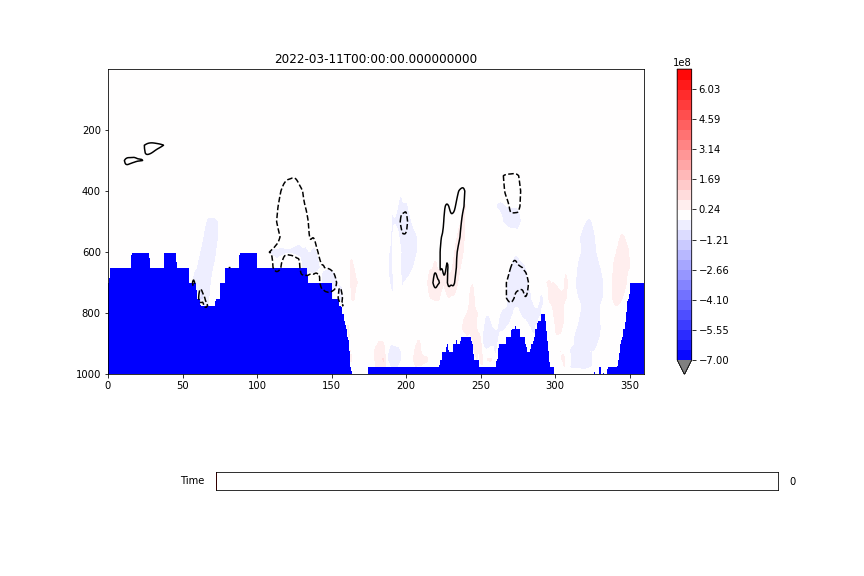

In [33]:
%matplotlib widget
# Create subplot

which_lat = -75
lat_idx = era_fncts.get_lat_idx(which_lat)

fig, ax = plt.subplots(figsize=(12,8))
plt.subplots_adjust(bottom=0.35)
 
# Create and plot sine wave
plot_moist_value = full_event_ds_aht.eddy_moist_int.sel(latitude=which_lat).isel(time=0)
plot_dry_value = full_event_ds_aht.eddy_dry_int.sel(latitude=which_lat).isel(time=0)

plot_moist_value.values[zon_norms[:,lat_idx,:]==0] = -1e50

contf=plt.contourf(lons, levels, plot_moist_value, levels=np.linspace(-0.7e9, 0.7e9, 30), cmap='bwr',
                  extend='min')
plt.contour(lons, levels, plot_dry_value, levels=np.linspace(-1.5e9, 1.5e9, 6), colors='k')
plt.colorbar(contf)
contf.cmap.set_under('grey')
contour_axis = plt.gca()
plt.gca().invert_yaxis()
plt.title(plot_moist_value.time.values)
 
# Create axes for frequency and amplitude sliders
axtime = plt.axes([0.25, 0.15, 0.65, 0.03])
 
# Create a slider from 0.0 to 20.0 in axes axfreq
# with 3 as initial value
which_time = Slider(axtime, 'Time', 0.0, 40.0, valstep=1.0)
 
# Create fuction to be called when slider value is changed
 
def update(val):
    new_time = which_time.val
    
    contour_axis.clear()
    
    plot_moist_value = full_event_ds_aht.eddy_moist_int.sel(latitude=which_lat).isel(time=int(new_time))
    plot_dry_value = full_event_ds_aht.eddy_dry_int.sel(latitude=which_lat).isel(time=int(new_time))
    
    plot_moist_value.values[zon_norms[:,lat_idx,:]==0] = -1e50
    contf=contour_axis.contourf(lons, levels, plot_moist_value, levels=np.linspace(-0.7e9, 0.7e9, 30),
                                cmap='bwr', extend='min')
    contour_axis.contour(lons, levels, plot_dry_value, levels=np.linspace(-1.5e9, 1.5e9, 6), colors='k')
    
    contf.cmap.set_under('grey')
    contour_axis.invert_yaxis()
    plt.title(plot_moist_value.time.values)
    plt.draw()  
    
    
# Call update function when slider value is changed
which_time.on_changed(update)

# display graph
plt.show()

### Break down dry and moist at 75S

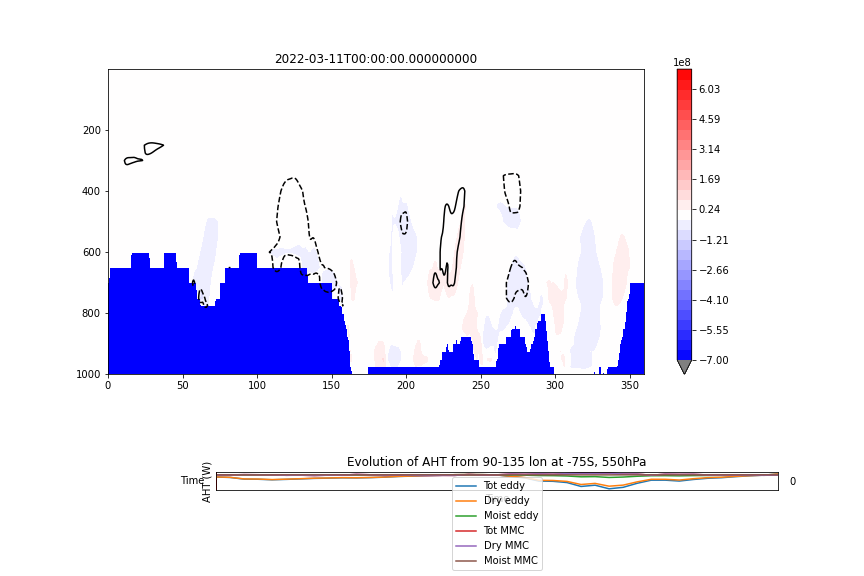

In [34]:
aht_chunk = full_event_ds_aht.sel(latitude=-75, longitude=slice(90, 135), level=550).mean(['longitude'])
#aht_chunk = full_event_ds_aht.sel(latitude=-75, longitude=slice(135, 180), level=slice(0, 600)).sum(['level']).mean(['longitude'])

which_geometry = geometry[era_fncts.get_lat_idx(-75)]
plt.plot(range(60), aht_chunk.eddy_tot_int * which_geometry, label='Tot eddy')
plt.plot(range(60), aht_chunk.eddy_dry_int * which_geometry, label='Dry eddy')
plt.plot(range(60), aht_chunk.eddy_moist_int * which_geometry, label='Moist eddy')

plt.plot(range(60), aht_chunk.mmc_tot_int * which_geometry, label='Tot MMC')
plt.plot(range(60), aht_chunk.mmc_dry_int * which_geometry, label='Dry MMC')
plt.plot(range(60), aht_chunk.mmc_moist_int * which_geometry, label='Moist MMC')

plt.legend(loc=0)

plt.xlabel('Time')
plt.ylabel('AHT (W)')
plt.title('Evolution of AHT from 90-135 lon at -75S, 550hPa')

#plt.savefig('figures/4_20_22_meeting/aht_evolution_90_135_-75lat_550hPa')

plt.show()

<ipython-input-35-730763092d03>:28: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))
  contf.cmap.set_under('grey')


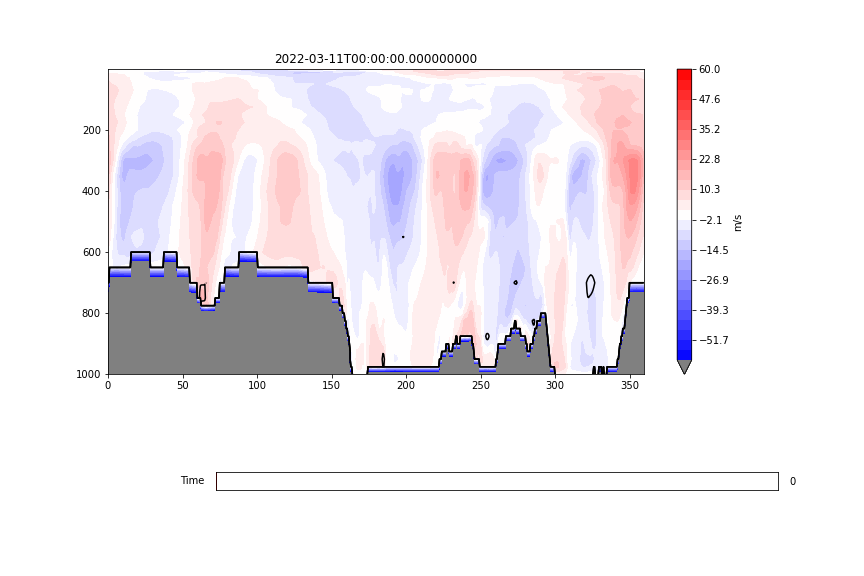

In [35]:
%matplotlib widget
# Create subplot

which_lat = -75
lat_idx = era_fncts.get_lat_idx(which_lat)

fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(bottom=0.35)

field1 = full_event_ds_aht.eddy_moist_int
field1_contours = np.linspace(-.3e9, .3e9, 6)

field2 = full_event_ds_vcomp.v.sel(expver=5)
#field2_contours = np.linspace(-1, 1, 30)
field2_contours = np.linspace(-60, 60, 30)
 
# Create and plot sine wave
plot_field1 = field1.sel(latitude=which_lat).isel(time=0)
initial_field2 = field2.isel(time=0) * zon_norms[:,:,:]
plot_field2 = initial_field2.sel(latitude=which_lat) / np.amax(zon_norms[:,lat_idx,:], axis=1)[:,None]

plot_field2.values[zon_norms[:,lat_idx,:]==0] = -100

contf = plt.contourf(lons, levels, plot_field2, levels=field2_contours, cmap='bwr', extend='min')
plt.contour(lons, levels, plot_field1, levels=field1_contours, colors='k')

plt.colorbar(contf, label='m/s')
contf.cmap.set_under('grey')
contour_axis = plt.gca()
plt.gca().invert_yaxis()
plt.title(plot_field1.time.values)
 
# Create axes for frequency and amplitude sliders
axtime = plt.axes([0.25, 0.15, 0.65, 0.03])
 
# Create a slider from 0.0 to 20.0 in axes axfreq
# with 3 as initial value
which_time = Slider(axtime, 'Time', 0.0, 40.0, valstep=1.0)
 
# Create fuction to be called when slider value is changed
 
def update(val):
    
    new_time = which_time.val
    contour_axis.clear()
    contour_axis.invert_yaxis()
    
    
    plot_field1 = field1.sel(latitude=which_lat).isel(time=int(new_time))
    initial_field2 = field2.isel(time=int(new_time)) * zon_norms[:,:,:]
    plot_field2 = initial_field2.sel(latitude=which_lat)/ np.amax(zon_norms[:,lat_idx,:], axis=1)[:,None]
    plot_field2.values[zon_norms[:,lat_idx,:]==0] = -100
    
    contf = contour_axis.contourf(lons, levels, plot_field2, levels=field2_contours,
                                  cmap='bwr', extend='min')
    contour_axis.contour(lons, levels, plot_field1.values, levels=field1_contours, colors='k')
    contf.cmap.set_under('grey')
    plt.title(plot_field1.time.values)
    plt.draw()  
    
    
# Call update function when slider value is changed
which_time.on_changed(update)

# display graph
plt.show()

In [10]:
geopot_clima_files = sorted(glob('../era5_raw_data/geopotential/*'))

def add_time_dim(xda):
    xda = xda.expand_dims(year = [dt.datetime.now()])
    return xda

geopot_clima_ds = xr.open_mfdataset(geopot_clima_files, preprocess = add_time_dim)

geopot_clima_ds['year'] = range(1979, 2022, 1)

In [37]:
vcomp_clima_files = sorted(glob('era5_raw_data/vcomp/*'))

def add_time_dim(xda):
    xda = xda.expand_dims(year = [dt.datetime.now()])
    return xda

vcomp_clima_ds = xr.open_mfdataset(vcomp_clima_files, preprocess = add_time_dim)

vcomp_clima_ds['year'] = range(1980, 2022, 1)

In [75]:
temp_clima_files = sorted(glob('../era5_raw_data/temperature/*'))

def add_time_dim(xda):
    xda = xda.expand_dims(year = [dt.datetime.now()])
    return xda

temp_clima_ds = xr.open_mfdataset(temp_clima_files, preprocess = add_time_dim)

temp_clima_ds['year'] = range(1980, 2022, 1)

In [39]:
sphum_clima_files = sorted(glob('era5_raw_data/sphum/*'))

def add_time_dim(xda):
    xda = xda.expand_dims(year = [dt.datetime.now()])
    return xda

sphum_clima_ds = xr.open_mfdataset(sphum_clima_files, preprocess = add_time_dim)

sphum_clima_ds['year'] = range(1980, 2022, 1)

In [53]:
full_event_ds_geopot.z.isel(time=10, longitude=100, latitude=-6).sel(expver=5)

<xarray.DataArray 'z' (level: 37)>
array([460195.06   , 409313.25   , 380402.44   , 345314.4    ,
       322908.7    , 299412.47   , 254723.08   , 228847.47   ,
       196062.56   , 174381.34   , 151365.55   , 136967.34   ,
       125192.52   , 115240.37   , 106615.17   ,  99011.875  ,
        92239.83   ,  80709.05   ,  71061.94   ,  62581.64   ,
        54985.97   ,  48023.28   ,  41602.03   ,  35684.125  ,
        30300.047  ,  25152.375  ,  20241.125  ,  17892.266  ,
        15596.781  ,  13354.6875 ,  11173.609  ,   9045.906  ,
         6963.953  ,   4927.7656 ,   2937.3281 ,    985.03125,
         -929.1406 ], dtype=float32)
Coordinates:
    longitude  float32 50.0
    latitude   float32 -87.5
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
    expver     int32 5
    time       datetime64[ns] 2022-03-13T12:00:00
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

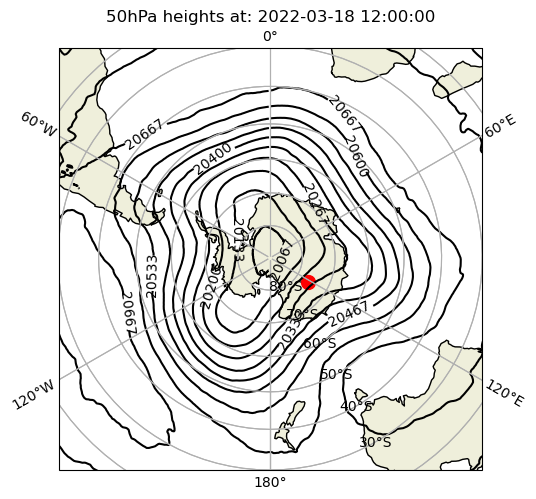

In [46]:
fig = plt.figure(figsize=[12, 8])
ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())

which_time = 30
which_level = 50

def fmt(x):
    rounded = f"{x:1.0f}"
    return rounded

# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

plot_field = full_event_ds_geopot.z.sel(expver=5, level=which_level, method='nearest') / g

cont=ax1.contour(lons, lats, plot_field.isel(time=which_time),
                   transform=ccrs.PlateCarree(), levels=np.linspace(20000, 22000, 31), colors='k')

geopot_mean = geopot_clima_ds.means.sel(month=3).mean(['year'])/g
geopot_std = geopot_clima_ds.stds.sel(month=3).mean(['year'])/g

anomaly = ((plot_field.isel(time=which_time) - geopot_mean)/geopot_std).values
#contf=ax1.contourf(lons, lats, np.ma.masked_array(anomaly, mask=(abs(anomaly)<=1)),
                   #transform=ccrs.PlateCarree(), levels=np.linspace(-6, 6, 21), cmap='gist_ncar', alpha=0.3)
ax1.clabel(cont, cont.levels, inline=True, fmt=fmt, fontsize=10)

ax1.coastlines()
ax1.add_feature(cfeat.LAND)
ax1.gridlines()

ax1.scatter(123, -76, transform=ccrs.PlateCarree(), s=100, color='r')

#get size and extent of axes:
axpos = ax1.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
#pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
#plt.colorbar(contf, cax=pos_cax, label='Std. Devs.')

time_str = str(pd.to_datetime(plot_field.isel(time=which_time).time.values))
ax1.set_title(str(which_level) + 'hPa heights at: ' + time_str)
ax1.gridlines(draw_labels=True)
#plt.savefig('figures/4_20_22_meeting/heights_' + time_str + '_' + str(which_level) + 'hPa')

plt.show()

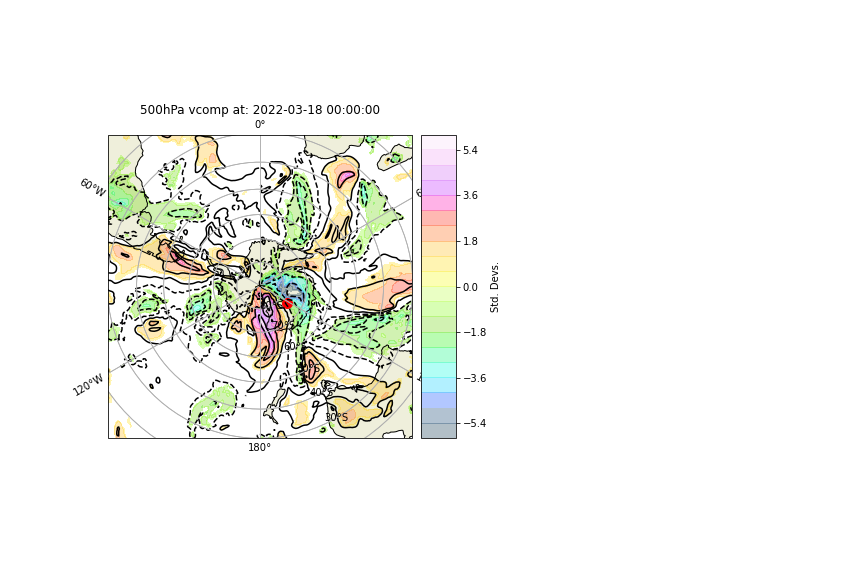

In [82]:
fig = plt.figure(figsize=[12, 8])
ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())

which_time = 28
which_level = 500

def fmt(x):
    rounded = f"{x:1.0f}"
    return rounded

# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

plot_field = full_event_ds_vcomp.v.sel(expver=5, level=which_level, method='nearest')

cont=ax1.contour(lons, lats, plot_field.isel(time=which_time),
                   transform=ccrs.PlateCarree(), levels=np.linspace(-30, 30, 6), colors='k')

vcomp_mean = vcomp_clima_ds.means.sel(month=3).mean(['year'])
vcomp_std = vcomp_clima_ds.stds.sel(month=3).mean(['year'])

anomaly = ((plot_field.isel(time=which_time) - vcomp_mean)/vcomp_std).values
contf=ax1.contourf(lons, lats, np.ma.masked_array(anomaly, mask=(abs(anomaly)<=1)),
                   transform=ccrs.PlateCarree(), levels=np.linspace(-6, 6, 21), cmap='gist_ncar', alpha=0.3)
#ax1.clabel(cont, cont.levels, inline=True, fmt=fmt, fontsize=10)

ax1.coastlines()
ax1.add_feature(cfeat.LAND)
ax1.gridlines()

ax1.scatter(123, -76, transform=ccrs.PlateCarree(), s=100, color='r')

#get size and extent of axes:
axpos = ax1.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(contf, cax=pos_cax, label='Std. Devs.')

time_str = str(pd.to_datetime(plot_field.isel(time=which_time).time.values))
ax1.set_title(str(which_level) + 'hPa vcomp at: ' + time_str)
ax1.gridlines(draw_labels=True)
#plt.savefig('figures/4_20_22_meeting/heights_' + time_str + '_' + str(which_level) + 'hPa')

plt.show()

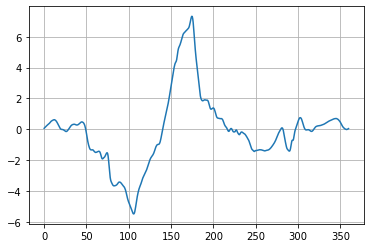

In [392]:
which_time = 30
which_lat = -75

plot_field = full_event_ds_vcomp.v.sel(expver=5, level=which_level, 
                                       latitude=which_lat, method='nearest')

vcomp_mean = vcomp_clima_ds.means.sel(month=3, latitude=which_lat).mean(['year'])
vcomp_std = vcomp_clima_ds.stds.sel(month=3, latitude=which_lat).mean(['year'])

anomaly = ((plot_field.isel(time=which_time) - vcomp_mean)/vcomp_std).values

plt.plot(lons, anomaly)

plt.grid()

plt.show()

-0.8410548827800578


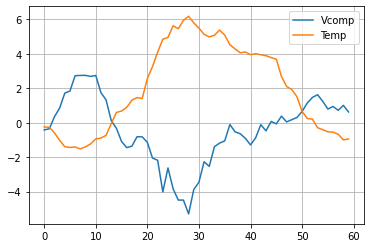

In [403]:
which_time = 30
which_lat1 = -72
which_lat2 = -75
which_lon1 = 100
which_lon2 = 120

vcomp_field = full_event_ds_vcomp.v.sel(expver=5, level=which_level, 
                                       latitude=which_lat1, longitude=which_lon1,
                                       method='nearest')

vcomp_mean = vcomp_clima_ds.means.sel(month=3, latitude=which_lat1,
                                     longitude=which_lon1).mean(['year'])
vcomp_std = vcomp_clima_ds.stds.sel(month=3, latitude=which_lat1,
                                   longitude=which_lon1).mean(['year'])

anomaly_vcomp = ((vcomp_field - vcomp_mean)/vcomp_std).values

temp_field = full_event_ds_temp.t.sel(expver=5, level=which_level, 
                                       latitude=which_lat2, longitude=which_lon2,
                                       method='nearest')

temp_mean = temp_clima_ds.means.sel(month=3, latitude=which_lat2,
                                     longitude=which_lon2).mean(['year'])
temp_std = temp_clima_ds.stds.sel(month=3, latitude=which_lat2,
                                   longitude=which_lon2).mean(['year'])

anomaly_temp = ((temp_field - temp_mean)/temp_std).values

plt.plot(range(60), anomaly_vcomp, label='Vcomp')
plt.plot(range(60), anomaly_temp, label='Temp')

print(np.corrcoef(anomaly_vcomp, anomaly_temp)[0,1])
      
plt.legend(loc=0)
plt.grid()

plt.show()

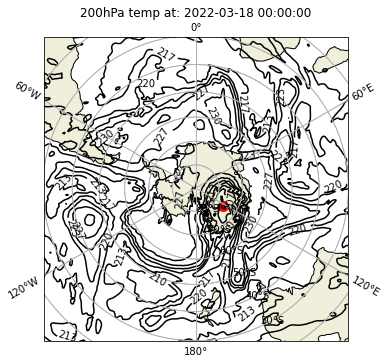

In [77]:
fig = plt.figure(figsize=[12, 8])
ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())

which_time = 28
which_level = 200

def fmt(x):
    rounded = f"{x:1.0f}"
    return rounded

# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

plot_field = full_event_ds_temp.t.sel(expver=5, level=which_level, method='nearest')

cont=ax1.contour(lons, lats, plot_field.isel(time=which_time),
                   transform=ccrs.PlateCarree(), levels=np.linspace(200, 230, 10), colors='k')

temp_mean = temp_clima_ds.means.sel(month=3).mean(['year'])
temp_std = temp_clima_ds.stds.sel(month=3).mean(['year'])

anomaly = ((plot_field.isel(time=which_time) - temp_mean)/temp_std).values
#contf=ax1.contourf(lons, lats, np.ma.masked_array(anomaly, mask=(abs(anomaly)<=1)),
                   #transform=ccrs.PlateCarree(), levels=np.linspace(-6, 6, 21), cmap='gist_ncar', alpha=0.3)
ax1.clabel(cont, cont.levels, inline=True, fmt=fmt, fontsize=10)

ax1.coastlines()
ax1.add_feature(cfeat.LAND)
ax1.gridlines()

ax1.scatter(123, -76, transform=ccrs.PlateCarree(), s=100, color='r')

#get size and extent of axes:
axpos = ax1.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
#pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
#plt.colorbar(contf, cax=pos_cax, label='Std. Devs.')

time_str = str(pd.to_datetime(plot_field.isel(time=which_time).time.values))
ax1.set_title(str(which_level) + 'hPa temp at: ' + time_str)
ax1.gridlines(draw_labels=True)
#plt.savefig('figures/4_20_22_meeting/heights_' + time_str + '_' + str(which_level) + 'hPa')

plt.show()

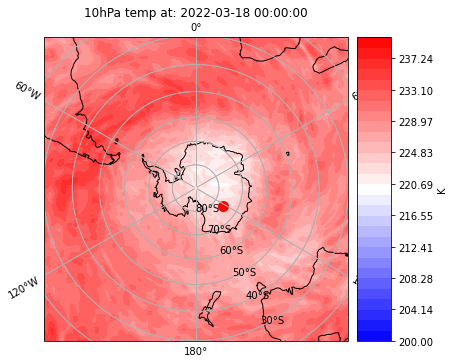

In [112]:
fig = plt.figure(figsize=[12, 8])
ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())

which_time = 28
which_level = 10

def fmt(x):
    rounded = f"{x:1.0f}"
    return rounded

# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

plot_field = full_event_ds_temp.t.sel(expver=5, level=which_level, method='nearest')

contf=ax1.contourf(lons, lats, plot_field.isel(time=which_time),
                   transform=ccrs.PlateCarree(), levels=np.linspace(200, 240, 30), cmap='bwr')

#temp_mean = temp_clima_ds.means.sel(month=3).mean(['year'])
#temp_std = temp_clima_ds.stds.sel(month=3).mean(['year'])

#anomaly = ((plot_field.isel(time=which_time) - temp_mean)/temp_std).values
#contf=ax1.contourf(lons, lats, np.ma.masked_array(anomaly, mask=(abs(anomaly)<=1)),
                   #transform=ccrs.PlateCarree(), levels=np.linspace(-6, 6, 21), cmap='gist_ncar', alpha=0.3)
#ax1.clabel(cont, cont.levels, inline=True, fmt=fmt, fontsize=10)

ax1.coastlines()
ax1.add_feature(cfeat.LAND)
ax1.gridlines()

ax1.scatter(123, -76, transform=ccrs.PlateCarree(), s=100, color='r')

#get size and extent of axes:
axpos = ax1.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(contf, cax=pos_cax, label='K')

time_str = str(pd.to_datetime(plot_field.isel(time=which_time).time.values))
ax1.set_title(str(which_level) + 'hPa temp at: ' + time_str)
ax1.gridlines(draw_labels=True)
#plt.savefig('figures/4_20_22_meeting/heights_' + time_str + '_' + str(which_level) + 'hPa')

plt.show()

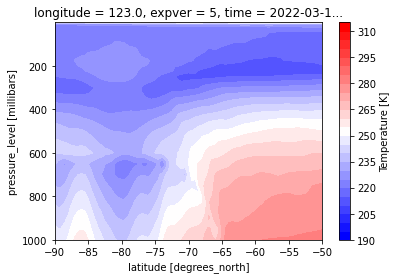

In [103]:
full_event_ds_temp.t.sel(expver=5, longitude=123, method='nearest').isel(time=15).plot.contourf(levels=30, cmap='bwr')

plt.gca().invert_yaxis()

plt.xlim([-90, -50])
plt.show()

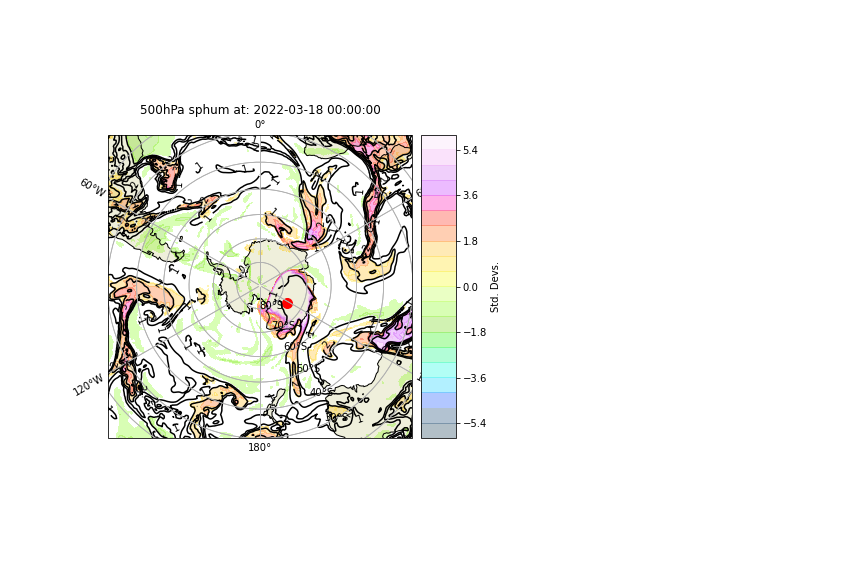

In [89]:
fig = plt.figure(figsize=[12, 8])
ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())

which_time = 28
which_level = 500

def fmt(x):
    rounded = f"{x:1.0f}"
    return rounded

# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

plot_field = full_event_ds_sphum.q.sel(expver=5, level=which_level, method='nearest')

cont=ax1.contour(lons, lats, plot_field.isel(time=which_time) * 1000,
                   transform=ccrs.PlateCarree(), levels=np.linspace(0, 4, 6), colors='k')

sphum_mean = sphum_clima_ds.means.sel(month=3).mean(['year'])
sphum_std = sphum_clima_ds.stds.sel(month=3).mean(['year'])

anomaly = ((plot_field.isel(time=which_time) - sphum_mean)/sphum_std).values
contf=ax1.contourf(lons, lats, np.ma.masked_array(anomaly, mask=(abs(anomaly)<=1)),
                   transform=ccrs.PlateCarree(), levels=np.linspace(-6, 6, 21), cmap='gist_ncar', alpha=0.3)
ax1.clabel(cont, cont.levels, inline=True, fmt=fmt, fontsize=10)

ax1.coastlines()
ax1.add_feature(cfeat.LAND)
ax1.gridlines()

ax1.scatter(123, -76, transform=ccrs.PlateCarree(), s=100, color='r')

#get size and extent of axes:
axpos = ax1.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(contf, cax=pos_cax, label='Std. Devs.')

time_str = str(pd.to_datetime(plot_field.isel(time=which_time).time.values))
ax1.set_title(str(which_level) + 'hPa sphum at: ' + time_str)
ax1.gridlines(draw_labels=True)
#plt.savefig('figures/4_20_22_meeting/heights_' + time_str + '_' + str(which_level) + 'hPa')

plt.show()

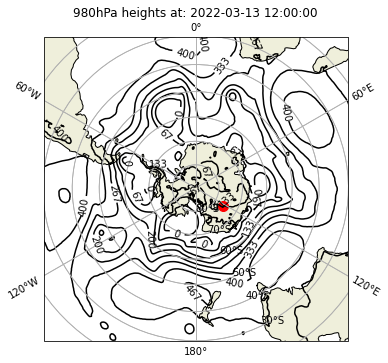

In [381]:
fig = plt.figure(figsize=[12, 8])
ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())

which_time = 10
which_level = 980

def fmt(x):
    rounded = f"{x:1.0f}"
    return rounded

# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

plot_field = full_event_ds_geopot.z.sel(expver=5, level=which_level, method='nearest') / g

cont=ax1.contour(lons, lats, plot_field.isel(time=which_time),
                   transform=ccrs.PlateCarree(), levels=np.linspace(0, 2000, 31), colors='k')

ax1.clabel(cont, cont.levels, inline=True, fmt=fmt, fontsize=10)

ax1.coastlines()
ax1.add_feature(cfeat.LAND)
ax1.gridlines()

ax1.scatter(123, -76, transform=ccrs.PlateCarree(), s=100, color='r')


time_str = str(pd.to_datetime(plot_field.isel(time=which_time).time.values))
ax1.set_title(str(which_level) + 'hPa heights at: ' + time_str)
ax1.gridlines(draw_labels=True)
#plt.savefig('figures/4_20_22_meeting/heights_' + time_str + '_' + str(which_level) + 'hPa')

plt.show()

In [99]:
temp_field = full_event_ds_temp.t.sel(expver=5, level=which_level, method='nearest').isel(time=slice(10, 50))
vcomp_field = full_event_ds_vcomp.v.sel(expver=5, level=which_level, method='nearest').isel(time=slice(10, 50))

corr_coefs = np.zeros((len(lons), len(lats)))

for i, lon in enumerate(lons):
    
    for j, lat in enumerate(lats):
        
        corr_coefs[i,j] = np.corrcoef(temp_field.sel(latitude=lat, longitude=lon),
                                      vcomp_field.sel(latitude=lat, longitude=lon))[1,0]

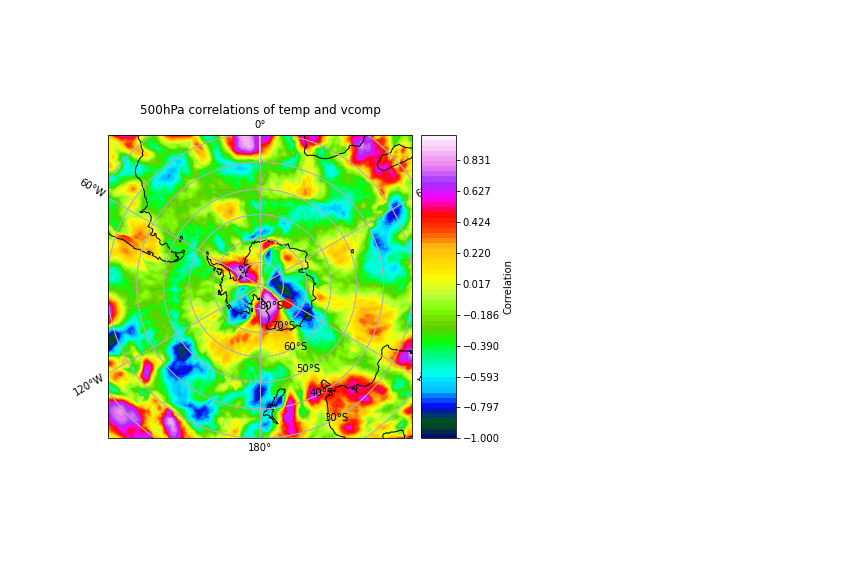

In [100]:
fig = plt.figure(figsize=[12, 8])
ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())

which_level = 500

def fmt(x):
    rounded = f"{x:1.0f}"
    return rounded

# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())                 
                      
contf=ax1.contourf(lons, lats, corr_coefs.T,
                   transform=ccrs.PlateCarree(), levels=np.linspace(-1, 1, 60), cmap='gist_ncar')

#ax1.clabel(cont, cont.levels, inline=True, fmt=fmt, fontsize=10)

#get size and extent of axes:
axpos = ax1.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(contf, cax=pos_cax, label='Correlation')

ax1.coastlines()
ax1.add_feature(cfeat.LAND)
ax1.gridlines()

ax1.scatter(123, -76, transform=ccrs.PlateCarree(), s=100, color='r')

#time_str = str(pd.to_datetime(plot_field.isel(time=which_time).time.values))
ax1.set_title(str(which_level) + 'hPa correlations of temp and vcomp')
ax1.gridlines(draw_labels=True)
#plt.savefig('figures/4_20_22_meeting/heights_' + time_str + '_' + str(which_level) + 'hPa')

plt.show()

In [98]:
def fmt(x):
    rounded = f"{x:1.0f}"
    return rounded

for i in range(60):
    
    fig = plt.figure(figsize=[12, 8])
    ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())

    which_time = i
    which_level = 500


    ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

    plot_field = full_event_ds_temp.t.sel(expver=5, level=which_level, method='nearest')

    cont=ax1.contour(lons, lats, plot_field.isel(time=which_time),
                       transform=ccrs.PlateCarree(), levels=np.linspace(240, 280, 10), colors='k')

    temp_mean = temp_clima_ds.means.sel(month=3).mean(['year'])
    temp_std = temp_clima_ds.stds.sel(month=3).mean(['year'])

    anomaly = ((plot_field.isel(time=which_time) - temp_mean)/temp_std).values
    contf=ax1.contourf(lons, lats, np.ma.masked_array(anomaly, mask=(abs(anomaly)<=1)),
                       transform=ccrs.PlateCarree(), levels=np.linspace(-6, 6, 21), cmap='gist_ncar', alpha=0.3)
    ax1.clabel(cont, cont.levels, inline=True, fmt=fmt, fontsize=10)

    ax1.coastlines()
    ax1.add_feature(cfeat.LAND)
    ax1.gridlines()

    ax1.scatter(123, -76, transform=ccrs.PlateCarree(), s=100, color='r')

    #get size and extent of axes:
    axpos = ax1.get_position()
    pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
    pos_y = axpos.y0
    cax_width = 0.04
    cax_height = axpos.height
    #create new axes where the colorbar should go.
    #it should be next to the original axes and have the same height!
    pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
    plt.colorbar(contf, cax=pos_cax, label='Std. Devs.')

    time_str = str(pd.to_datetime(plot_field.isel(time=which_time).time.values))
    ax1.set_title(str(which_level) + 'hPa temp at: ' + time_str)
    ax1.gridlines(draw_labels=True)

   # plt.savefig('figures/antarctic_figs/temp_' + time_str + '_' + str(which_level) + 'hPa')

    plt.close()
    
    #plt.show()
    

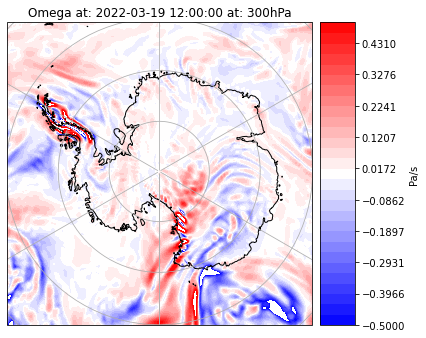

In [388]:
fig = plt.figure(figsize=[12, 8])
ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())

which_time = 34
which_level =300

# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

plot_field = full_event_ds_omega.w.sel(expver=5, level=which_level, method='nearest')

contf=ax1.contourf(lons, lats, plot_field.isel(time=which_time),
                   transform=ccrs.PlateCarree(), levels=np.linspace(-.5, .5, 30), cmap='bwr')


ax1.coastlines()
ax1.gridlines()

#get size and extent of axes:
axpos = ax1.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(contf, cax=pos_cax, label='Pa/s')

time_str = str(pd.to_datetime(plot_field.isel(time=which_time).time.values))
ax1.set_title('Omega at: ' + time_str + ' at: ' + str(which_level) + 'hPa')

#plt.savefig('figures/4_20_22_meeting/omega_' + time_str + '_' + str(which_level) + 'hPa')

plt.show()

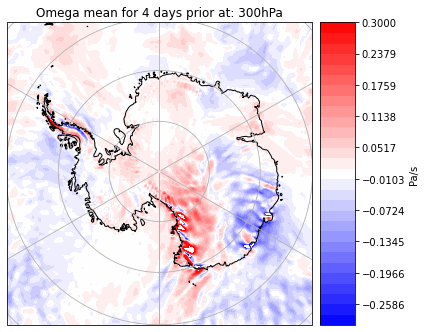

In [349]:
fig = plt.figure(figsize=[12, 8])
ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())

which_level = 300

# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

plot_field = full_event_ds_omega.w.sel(expver=5, level=which_level, method='nearest')

contf=ax1.contourf(lons, lats, plot_field.isel(time=slice(20, 40)).mean(['time']),
                   transform=ccrs.PlateCarree(), levels=np.linspace(-.3, .3, 30), cmap='bwr')


ax1.coastlines()
ax1.gridlines()

#get size and extent of axes:
axpos = ax1.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(contf, cax=pos_cax, label='Pa/s')

#time_str = str(pd.to_datetime(plot_field.isel(time=which_time).time.values))
ax1.set_title('Omega mean for 4 days prior at: ' + str(which_level) + 'hPa')

#plt.savefig('figures/4_20_22_meeting/omega_4_days_prior_ave_' + str(which_level) + 'hPa')

plt.show()

NameError: name 'ds_lw' is not defined

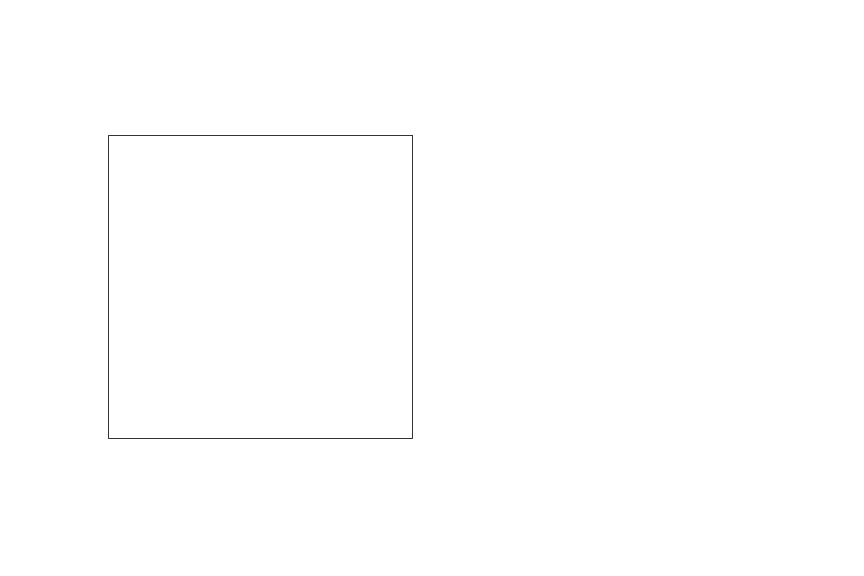

In [282]:
fig = plt.figure(figsize=[12, 8])
ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())

which_time = 34
which_level =300

# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

lats_subset = lats[-61:]
which_field = ds_lw.strd.sel(expver=5)
lw_mean = which_field.mean(['time'])
lw_std = which_field.std(['time'])

field_time_slice = which_field.sel(time=slice('2022-03-17-12:00', '2022-03-17-12:00')).mean(['time'])
plot_field = (field_time_slice - lw_mean) / lw_std

contf=ax1.contourf(lons, lats_subset, plot_field,
                   transform=ccrs.PlateCarree(), levels=np.linspace(-5, 5, 30), cmap='bwr')


ax1.coastlines()
ax1.gridlines()

#get size and extent of axes:
axpos = ax1.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(contf, cax=pos_cax, label='Std. Devs.')

#time_str = str(pd.to_datetime(plot_field.isel(time=which_time).time.values))
ax1.set_title('Downwelling surface LW at 3-17-22 12z')

#plt.savefig('figures/4_20_22_meeting/downwelling_surf_lw_3_17_12z_std_devs')

plt.show()

In [396]:
dome_c_temp = full_event_ds_temp.t.sel(expver=5, latitude=-75.1, longitude=123.3, method='nearest')
dome_c_sphum = full_event_ds_sphum.q.sel(expver=5, latitude=-75.1, longitude=123.3, method='nearest')

dome_c_mix_ratio = dome_c_sphum / (1-dome_c_sphum)

dome_c_virtual_temp = dome_c_temp * (dome_c_mix_ratio + 0.622) / (0.622 * (1 + dome_c_mix_ratio))

[-6.4251251e+00 -6.4241104e+00 -5.4725823e+00 -3.0464668e+00
 -2.0125947e+00 -1.0700860e+00 -2.5310898e-01 -2.9572550e-02
 -8.2134251e-03 -2.6602682e-03 -1.3537385e-02 -1.9916687e-02
 -4.2427368e-02 -7.0247799e-02 -5.1159058e-02  5.0750733e-03
  3.9762877e-02  8.9774631e-02  1.2651260e-01  1.1899643e-01
  9.6060336e-02  7.6966248e-02  5.2106477e-02 -2.8218079e-02
 -1.9947968e-02  5.8384094e-02  6.3560687e-02  6.1599731e-02
  5.9425659e-02  5.8129884e-02  5.6936644e-02  5.5977784e-02
  5.4557495e-02  5.3286742e-02  5.1965334e-02  5.0794069e-02
  5.0681151e-02]
0.056017637


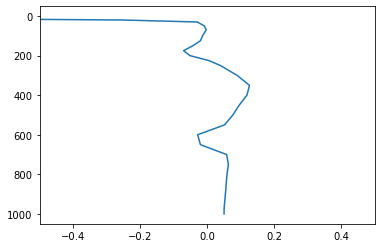

In [408]:
column_virt_temps = dome_c_virtual_temp.isel(time=slice(10, 30)).mean(['time'])
#plt.plot(column_virt_temps, levels)
plt.plot(np.gradient(column_virt_temps, levels), levels)

print(np.gradient(column_virt_temps, levels))
print(np.mean(np.gradient(column_virt_temps, levels)[15:]))
plt.gca().invert_yaxis()

plt.xlim([-0.5, 0.5])
plt.show()

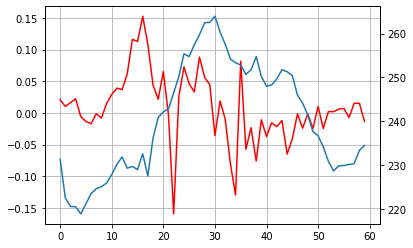

In [391]:
%matplotlib inline
dome_c_temp = full_event_ds_temp.t.sel(expver=5, latitude=-75.1, longitude=123.3, level=650, method='nearest')
#dome_c_lw_dn = ds_lw.strd.sel(expver=5, latitude=-75.1, longitude=123.3, method='nearest').sel(time=slice('2022-03-11-00:00', '2022-03-20-18:00'))
dome_c_omega = full_event_ds_omega.w.sel(expver=5, latitude=-75.1, longitude=123.3, method='nearest').sel(level=slice(300, 750)).mean(['level'])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(60), dome_c_omega, color='r', label='lw')

plt.grid()

ax2 = ax.twinx()

ax2.plot(range(60), dome_c_temp, label='temp')

plt.show()

In [24]:
np.shape(aht_weights)

(37, 361, 720)

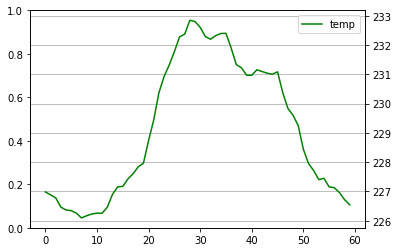

In [235]:
%matplotlib inline

which_lat = -75
which_lon = 123
lat_idx = era_fncts.get_lat_idx(which_lat)
lon_idx = era_fncts.get_lon_idx(which_lon)

this_weight = aht_weights[:,lat_idx, lon_idx]

dome_c_temp = full_event_ds_temp.t.sel(expver=5, latitude=-75, longitude=123)
dome_c_surf_temp = full_event_ds_temp.t.sel(expver=5, latitude=-75, longitude=123, level=650, method='nearest')
dome_c_sphum = full_event_ds_sphum.q.sel(expver=5, latitude=-75, longitude=123)
dome_c_geopot = full_event_ds_geopot.z.sel(expver=5, latitude=-75, longitude=123)

temp_weight = dome_c_temp.values * this_weight / np.nansum(this_weight)
sphum_weight = dome_c_sphum.values * this_weight / np.nansum(this_weight)
geopot_weight = dome_c_geopot.values * this_weight / np.nansum(this_weight)
#print(np.shape(temp_weight))

fig = plt.figure()
ax = fig.add_subplot(111)
temp_vert_ave = np.nansum(temp_weight, axis=1) * cp
sphum_vert_ave = np.nansum(sphum_weight, axis=1) * L
geopot_vert_ave = np.nansum(geopot_weight, axis=1)
total_vert_ave = temp_vert_ave + sphum_vert_ave + geopot_vert_ave

ax2 = ax.twinx()

ax2.plot(range(60), temp_vert_ave / cp, color='g', label='temp')

#ax2.plot(range(60), dome_c_surf_temp, color='r', label='temp')
plt.grid()



#ax.plot(range(60), sphum_vert_ave / cp, color='b', label='sphum')
#ax.plot(range(60), geopot_vert_ave / cp, color='r', label='geopot')
#ax.plot(range(60), total_vert_ave / cp, color='k', label='total')

plt.legend(loc=0)
plt.show()

In [236]:
np.nansum(dome_c_temp.isel(time=28).values * this_weight - dome_c_temp.isel(time=7).values * this_weight)/ np.nansum(this_weight)

6.749808799005722

In [99]:
dome_c_temp.mean(['level']).isel(time=28) - dome_c_temp.mean(['level']).isel(time=7)

<xarray.DataArray 't' ()>
array(11.495941, dtype=float32)
Coordinates:
    longitude  float32 123.0
    latitude   float32 -75.0
    expver     int32 5

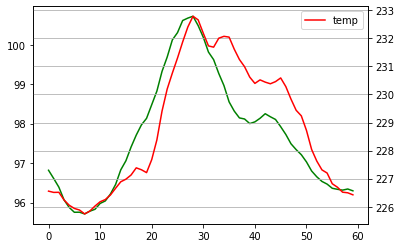

In [46]:
%matplotlib inline

which_lat = -75
which_lon1 = 90
which_lon2 = 135
lat_idx = era_fncts.get_lat_idx(which_lat)
lon_idx1 = era_fncts.get_lon_idx(which_lon1)
lon_idx2 = era_fncts.get_lon_idx(which_lon2)

this_weight = aht_weights[:,lat_idx, lon_idx1:lon_idx2]

dome_c_temp = full_event_ds_temp.t.sel(expver=5, latitude=which_lat, longitude=slice(which_lon1, which_lon2-.1))
dome_c_sphum = full_event_ds_sphum.q.sel(expver=5, latitude=which_lat, longitude=slice(which_lon1, which_lon2-.1))
dome_c_geopot = full_event_ds_geopot.z.sel(expver=5, latitude=which_lat, longitude=slice(which_lon1, which_lon2-.1))

#print(np.shape(this_weight))
temp_weight = dome_c_temp.values * this_weight[None,:,:] / np.nansum(this_weight, axis=0)[None,None,:]
sphum_weight = dome_c_sphum.values * this_weight[None,:,:] / np.nansum(this_weight, axis=0)[None,None,:]
geopot_weight = dome_c_geopot.values * this_weight[None,:,:] / np.nansum(this_weight, axis=0)[None,None,:]

fig = plt.figure()
ax = fig.add_subplot(111)
temp_vert_ave = np.nansum(temp_weight, axis=(1,2)) * cp
sphum_vert_ave = np.nansum(sphum_weight, axis=(1,2)) * L
geopot_vert_ave = np.nansum(geopot_weight, axis=(1,2))
total_vert_ave = temp_vert_ave + sphum_vert_ave + geopot_vert_ave

ax2 = ax.twinx()

ax2.plot(range(60), temp_vert_ave / cp / (which_lon2 - which_lon1) / 2, color='r', label='temp')

plt.grid()



#ax.plot(range(60), sphum_vert_ave / cp/ (which_lon2 - which_lon1) / 2, color='b', label='sphum')
ax.plot(range(60), geopot_vert_ave / cp/ (which_lon2 - which_lon1) / 2, color='g', label='geopot')
#ax.plot(range(60), total_vert_ave / cp / (which_lon2 - which_lon1) / 2, color='k', label='total')

plt.legend(loc=0)
plt.show()

In [246]:
np.cumsum(np.nansum(dome_c_temp.isel(time=28).values * this_weight - dome_c_temp.isel(time=7).values * this_weight, axis=1))/ np.cumsum(np.nansum(this_weight, axis=1))

array([ -3.31965298,  -4.04967689,  -4.53565649,  -5.5726922 ,
        -6.30087993,  -7.36021839,  -7.3215026 ,  -7.1269346 ,
        -7.37471814,  -7.68577025,  -8.03833164,  -8.25726643,
        -8.60213515,  -9.18897437, -10.12561054, -10.75100826,
       -10.72812609,  -8.54278635,  -5.81326255,  -3.26688065,
        -0.95866331,   1.02838313,   2.72403541,   4.31166305,
         5.28548982,   5.60006643,   5.68382893,   5.72754367,
         5.76461207,   5.79339154,   5.81082943,   5.82051682,
         5.82522452,   5.82287459,   5.81436178,   5.80345334,
         5.80401735])

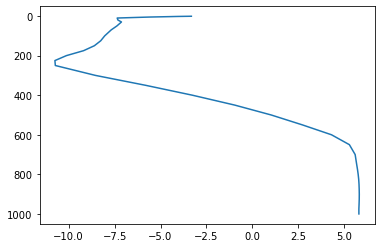

In [249]:
test = np.cumsum(np.nansum(dome_c_temp.isel(time=28).values * this_weight - dome_c_temp.isel(time=7).values * this_weight, axis=1))/ np.cumsum(np.nansum(this_weight, axis=1))

plt.plot(test, levels)

plt.gca().invert_yaxis()

plt.show()

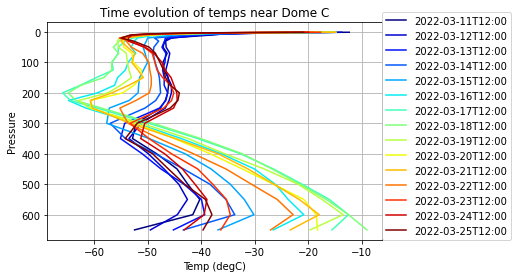

In [71]:
%matplotlib inline

times = np.arange(2, 60, 4)
colors = plt.cm.jet(np.linspace(0,1,len(times)))

for i, time in enumerate(times):
    which_time = time

    which_lat = -75.1
    lat_idx = era_fncts.get_lat_idx(which_lat)
    which_lon = 123.3
    lon_idx = era_fncts.get_lon_idx(which_lon)

    dome_c_temp = full_event_ds_temp.t.sel(expver=5, latitude=which_lat, longitude=which_lon, method='nearest').isel(time=which_time)

    specific_zon_norm = zon_norms[:,lat_idx, lon_idx]

    specific_zon_norm[specific_zon_norm>0] = 1
    plot_temp = dome_c_temp * specific_zon_norm

    #zon_norms[:,lat_idx, lon_idx] / np.amax(zon_norms[:,lat_idx, lon_idx])

    plot_temp[plot_temp<100] = np.nan
    plt.plot(plot_temp - 273, levels, color=colors[i], label=str(dome_c_temp.time.values)[:16])

plt.legend(loc=[1,0])
plt.gca().invert_yaxis()

plt.grid()

plt.xlabel('Temp (degC)')
plt.ylabel('Pressure')

plt.title('Time evolution of temps near Dome C')

#plt.savefig('figures/4_20_22_meeting/dome_c_atmos_column_temp_evolution')

plt.show()

In [72]:
dome_c_temp

<xarray.DataArray 't' (level: 37)>
array([252.11688, 240.8518 , 233.54967, 226.23912, 222.57649, 219.74762,
       218.04652, 220.35246, 223.26324, 224.4351 , 225.28355, 225.9619 ,
       226.34412, 227.21777, 228.90417, 228.63747, 227.19678, 221.0434 ,
       218.80676, 223.91638, 226.87335, 229.88704, 233.77437, 234.99664,
       233.33965, 236.61795, 239.73453, 241.27182, 242.70831, 244.1217 ,
       245.50359, 246.87286, 248.20435, 249.50012, 250.7686 , 252.02658,
       253.22784], dtype=float32)
Coordinates:
    longitude  float32 123.5
    latitude   float32 -75.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
    expver     int32 5
    time       datetime64[ns] 2022-03-25T12:00:00
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [382]:
col_names = ['Location', 'Unknown', 'Year', 'Month', 'Day', 'Hour', 'Minute',
             'Unkown2', 'Delta', 'Latitude', 'Longitude', 'Level', 'Pressure', 'Temperature']
             

traj_data = pd.read_csv('antarctica_trajectory_data.csv', header=None, names=col_names)

In [384]:
traj_data

Location  Unknown  Year  Month  Day  Hour  Minute  Unkown2  Delta  \
0           1        1    22      3   19     4       0        2      0   
1           2        1    22      3   19     4       0        2      0   
2           3        1    22      3   19     4       0        2      0   
3           4        1    22      3   19     4       0        2      0   
4           5        1    22      3   19     4       0        2      0   
..        ...      ...   ...    ...  ...   ...     ...      ...    ...   
868         5        1    22      3   15     4       0        2    -96   
869         6        1    22      3   15     4       0        2    -96   
870         7        1    22      3   15     4       0        2    -96   
871         8        1    22      3   15     4       0        2    -96   
872         9        1    22      3   15     4       0        2    -96   

     Latitude  Longitude   Level  Pressure  Temperature  
0     -78.000    110.000  1000.0     560.4        252.5  
1     -78.000    110.000   500.0     599.5        253.8  
2     -78.000    110.000   100.0     631.4        249.7  
3     -72.000    140.000  1000.0     635.8        265.4  
4     -72.000    140.000   500.0     678.1        264.7  
..        ...        ...     ...       ...          ...  
868   -51.504    129.942  1087.0     886.8        276.5  
869   -50.274    134.822   608.3     949.3        277.7  
870   -46.260    142.518  2532.5     753.4        274.5  
871   -52.309    129.286  1547.0     836.9        274.1  
872   -69.416    136.498    16.0     730.1        246.2  

[873 rows x 14 columns]

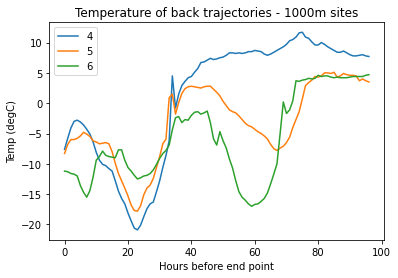

In [386]:
for locs in [4, 5, 6]:

    temp_data = traj_data.loc[traj_data['Location'] == locs]['Temperature']

    plt.plot(range(len(temp_data)), temp_data - 273, label=locs)

plt.legend(loc=0)

plt.ylabel('Temp (degC)')
plt.xlabel('Hours before end point')

plt.title('Temperature of back trajectories - 1000m sites')

#plt.savefig('figures/4_20_22_meeting/back_trajectories_temps_1000m')

plt.show()

/tdat/tylersc/mini3/envs/jupyter_copy/lib/python3.9/site-packages/xarray/core/accessor_dt.py:380: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/tdat/tylersc/mini3/envs/jupyter_copy/lib/python3.9/site-packages/xarray/core/accessor_dt.py:380: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


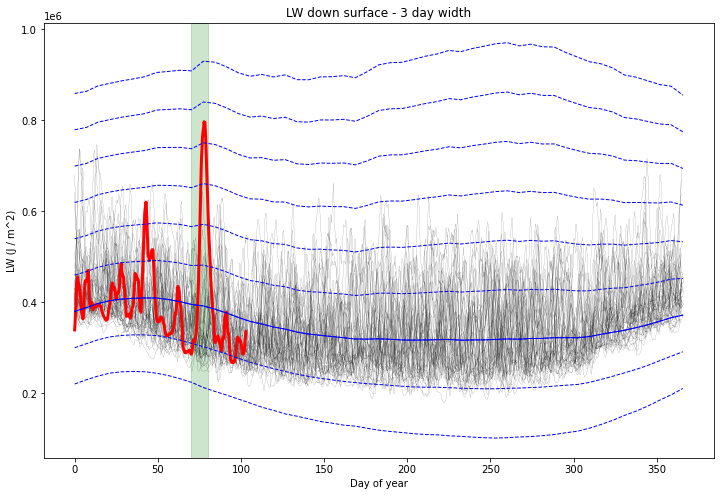

In [551]:
%matplotlib inline

plt.figure(figsize=(12,8))

groups = range(1979, 2023)

which_width=12

which_field = ds_lw.strd / which_width

mean_lw = which_field.groupby('time.weekofyear').mean('time').sel(expver=1)
std_lw = which_field.groupby('time.weekofyear').std('time').sel(expver=1)

running_sum_values = []
annual_maxs = []

#year_grouped = standardize(which_field).groupby('time.year')
year_grouped = which_field.groupby('time.year')

for group in groups:

    one_year = year_grouped[group].values
    
    if group == 2022:
        one_year = one_year[~np.isnan(one_year)]
        
    else:
        one_year = one_year[:,0]
    
    one_year_running_sum = running_sum(one_year, width=which_width)
    
    annual_maxs.append(np.min(one_year_running_sum))
    
    running_sum_values.append(one_year_running_sum)
    plot_color = 'k' if group != 2022 else 'r'
    line_width = .1 if group != 2022 else 3
    #plt.plot(range(len(one_year)), one_year, color=plot_color, linewidth=line_width)
    plt.plot(np.linspace(0, len(one_year_running_sum)//4, len(one_year_running_sum)), one_year_running_sum,
             color=plot_color, linewidth=line_width)


plt.plot(np.linspace(0, len(mean_lw)*6.9, len(mean_lw)), running_sum(mean_lw, width=which_width), color='b', linewidth=1)

for i in range(-2, 7):
    plt.plot(np.linspace(0, len(mean_lw)*6.9, len(mean_lw)), running_sum(mean_lw + i*std_lw, width=which_width),
             '--', color='b', linewidth=1)

plt.axvspan(70, 80, color='green', alpha=0.2)


plt.xlabel('Day of year')
plt.ylabel('LW (J / m^2)')

plt.title('LW down surface - 3 day width')

#plt.savefig('figures/4_20_22_meeting/lw_dn_surface_dome_c_3day_width')

plt.show()

In [545]:
ds_lw.strd         

<xarray.DataArray 'strd' (time: 63236, expver: 2)>
array([[452174.7 , 452174.7 ],
       [433228.44, 433228.44],
       [504677.3 , 504677.3 ],
       ...,
       [      nan, 481056.53],
       [      nan, 390541.8 ],
       [      nan, 427268.38]], dtype=float32)
Coordinates:
  * expver     (expver) int32 1 5
    longitude  float32 123.0
    latitude   float32 -75.0
  * time       (time) datetime64[ns] 1979-01-01T12:00:00 ... 2022-04-14T06:00:00
Attributes:
    units:      J m**-2
    long_name:  Surface thermal radiation downwards

In [526]:
no_seas

array([  2794.61039315, -38235.00508013, -46409.65348713, ...,
       205087.95374169,  58199.59825258, -55644.48279459])

In [116]:
circumf = 2 * np.pi * a * np.cos(np.deg2rad(65))

mse_change = 8.2e8

circumf/1e7

1.6918066566194474

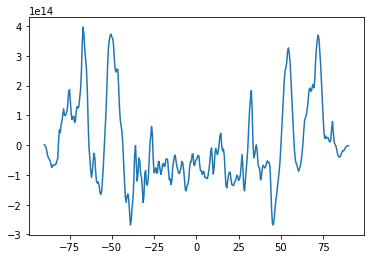

In [648]:
plt.plot(lats, np.gradient(aht_ds.eddy_aht.sel(time='2022-03-18-00:00').values))
         
plt.show()

In [196]:
aht_time_slice = aht_ds.total_aht.sel(time=slice('2022-03-15-00:00', '2022-03-19-00:00')).mean(['time']).values
np.gradient(aht_time_slice, lats * 111111)[era_fncts.get_lat_idx(-75)]

-1700463562.0556717

In [20]:
eddy_74s = np.load('aht_time_series/one_lat/eddy_total_-74deg_all_times_2022.npy') * geometry[era_fncts.get_lat_idx(-74)]
eddy_75s = np.load('aht_time_series/one_lat/eddy_total_-75deg_all_times_2022.npy') * geometry[era_fncts.get_lat_idx(-75)]
eddy_76s = np.load('aht_time_series/one_lat/eddy_total_-76deg_all_times_2022.npy') * geometry[era_fncts.get_lat_idx(-76)]

In [21]:
eddy_74s_moist = np.load('aht_time_series/moist_aht/eddy_moist_-74deg_all_times_2022.npy') * geometry[era_fncts.get_lat_idx(-74)]
eddy_75s_moist = np.load('aht_time_series/moist_aht/eddy_moist_-75deg_all_times_2022.npy') * geometry[era_fncts.get_lat_idx(-75)]
eddy_76s_moist = np.load('aht_time_series/moist_aht/eddy_moist_-76deg_all_times_2022.npy') * geometry[era_fncts.get_lat_idx(-76)]

In [22]:
eddy_combined = np.stack([eddy_74s, eddy_75s, eddy_76s], axis=1)
eddy_combined_moist = np.stack([eddy_74s_moist, eddy_75s_moist, eddy_76s_moist], axis=1)

eddy_combined_dry = eddy_combined - eddy_combined_moist

In [23]:
eddy_74_76_ds = xr.Dataset(
    data_vars = dict(eddy_aht=(['time', 'latitude', 'longitude'], eddy_combined),
                    eddy_aht_moist = (['time', 'latitude', 'longitude'], eddy_combined_moist),
                    eddy_aht_dry = (['time', 'latitude', 'longitude'], eddy_combined_dry)),
    coords=dict(time=pd.date_range('2022-01-01', '2022-03-31 18:00:00', freq='6H'),
                latitude=[-74, -75, -76],
                longitude=lons))

In [51]:
#test = eddy_74_76_ds.eddy_aht.sel(time=slice('2022-03-15-00:00', '2022-03-19-00:00')).sel(longitude=123).mean(['time']).values
test = eddy_74_76_ds.eddy_aht_moist.sel(time=slice('2022-03-15-00:00', '2022-03-19-00:00')).sel(longitude=slice(90, 135)).mean(['time', 'longitude']).values
test_lats = np.array([-74, -75, -76]) * 111111
np.gradient(test, test_lats)


array([-8.92597994e+08, -7.95455762e+08, -6.98313531e+08])

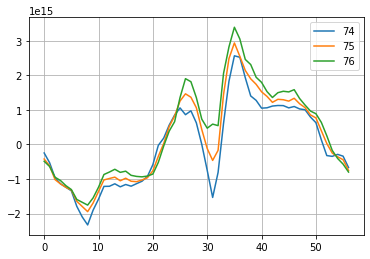

In [210]:
test = eddy_74_76_ds.eddy_aht.sel(time=slice('2022-03-10-00:00', '2022-03-24-00:00')).sel(longitude=slice(90, 180)).mean(['longitude'])

for test_lat in np.array([74, 75, 76]):
    
    plt.plot(range(57), test.sel(latitude=test_lat), label=test_lat)
plt.legend(loc=0)
plt.grid()
plt.show()

In [151]:
dome_c_aht_ave = aht_ds_local.eddy_aht.sel(time=slice('2022-03-15-00:00', '2022-03-19-00:00')).mean(['time']).sel(longitude=123)/720
sector_aht_ave = aht_ds_local.eddy_aht.sel(time=slice('2022-03-15-00:00', '2022-03-19-00:00')).sel(longitude=slice(90, 180)).mean(['time', 'longitude'])

lat_band_aht_ave = aht_ds.eddy_aht.sel(time=slice('2022-03-15-00:00', '2022-03-19-00:00')).mean(['time']).sel(latitude=-65)

print((dome_c_aht_ave/ lat_band_aht_ave).values)
print((sector_aht_ave/ lat_band_aht_ave).values)

0.011593329910131123
1.8253686691833093


In [144]:
test = eddy_75s_ds.eddy_aht.sel(time=slice('2022-03-10-00:00', '2022-03-25-00:00')).sel(longitude=slice(90, 165)).mean(['longitude'])

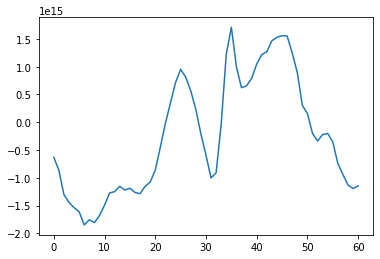

In [146]:
plt.plot(range(61), test)
plt.show()

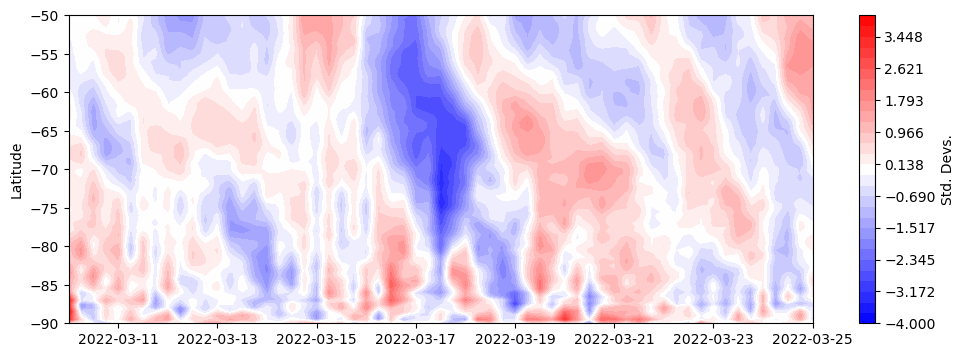

In [19]:
aht_ds_time_subset = aht_ds.sel(time=slice('2022-03-10-00:00', '2022-03-25-00:00'))

march_data = aht_ds.sel(time=aht_ds.time.dt.month.isin([3]))

plt.figure(figsize=(12, 4))
#plt.contourf(aht_ds_time_subset.time, lats, aht_ds_time_subset.eddy_aht.T,
             #levels=np.linspace(-1e16, 1e16, 30), cmap='bwr')

data_mean = march_data.total_aht.mean(['time'])
data_std = march_data.total_aht.std(['time'])
data_standardized = (aht_ds_time_subset.total_aht - data_mean) / data_std

plt.contourf(aht_ds_time_subset.time, lats, data_standardized.T,
             levels=np.linspace(-4, 4, 30), cmap='bwr')
plt.colorbar(label='Std. Devs.')

plt.ylim([-90, -50])

plt.ylabel('Latitude')

#plt.savefig('figures/4_20_22_meeting/zonal_aht_stdized_anoms')

plt.show()

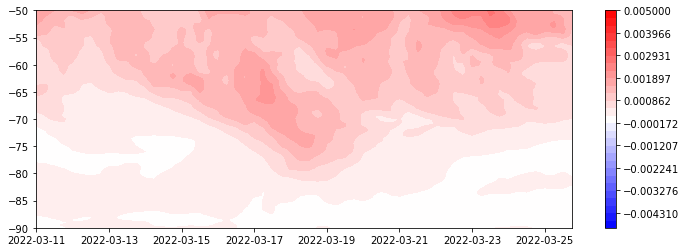

In [221]:
sphum_to_plot = full_event_ds_sphum.q.sel(expver=5).sel(longitude=slice(90, 180)).sel(level=650, method='nearest').mean(['longitude'])

plt.figure(figsize=(12, 4))

plt.contourf(sphum_to_plot.time, lats, sphum_to_plot.T,
             levels=np.linspace(-.005, .005, 30), cmap='bwr')
plt.colorbar()
plt.ylim([-90, -50])
plt.show()

### CERES data

In [44]:
ceres_ds = xr.open_dataset('antarctic_event/CERES_antarctic_data.nc')
ceres_lons = ceres_ds.lon
ceres_lats = ceres_ds.lat

In [43]:
ceres_ds

<xarray.Dataset>
Dimensions:                (time: 30, lon: 360, lat: 50)
Coordinates:
  * time                   (time) datetime64[ns] 2022-03-01 ... 2022-03-30
  * lon                    (lon) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * lat                    (lat) float32 -89.5 -88.5 -87.5 ... -42.5 -41.5 -40.5
Data variables: (12/18)
    toa_sw_clr_daily       (time, lat, lon) float32 ...
    toa_lw_clr_daily       (time, lat, lon) float32 ...
    toa_net_clr_daily      (time, lat, lon) float32 ...
    toa_alb_clr_daily      (time, lat, lon) float32 ...
    toa_solar_clr_daily    (time, lat, lon) float32 ...
    toa_sw_all_daily       (time, lat, lon) float32 ...
    ...                     ...
    sfc_net_sw_clr_daily   (time, lat, lon) float32 ...
    sfc_net_lw_clr_daily   (time, lat, lon) float32 ...
    sfc_sw_down_all_daily  (time, lat, lon) float32 ...
    sfc_lw_down_all_daily  (time, lat, lon) float32 ...
    sfc_net_sw_all_daily   (time, lat, lon) float32 ...
    sfc_net_lw_all_daily   (time, lat, lon) float32 ...
Attributes:
    title:        CERES FLASHFlux TISA Daily data.
    institution:  NASA Langley Research Center
    Conventions:  CF-1.4
    comment:      See values in latitude and longitudes dimensions.
    Version:      Version 4A
    DOI:          10.5067/TERRA-AQUA/CERES/FLASH_TISA_L3.004A
    Fill_Value:   Fill Value is -999.0

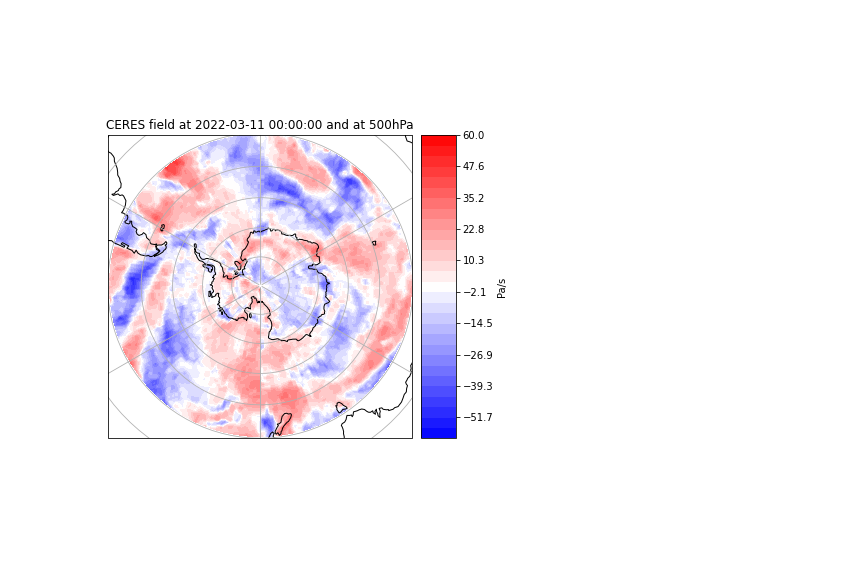

In [77]:
plt.close('all')

fig = plt.figure(figsize=[12, 8])
ax1 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())

# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

which_time = 10

ceres_mean = ceres_ds.mean(['time'])
plot_field = ceres_ds.isel(time=which_time) - ceres_mean

contf=ax1.contourf(ceres_lons, ceres_lats, plot_field.sfc_net_lw_all_daily,
                   transform=ccrs.PlateCarree(), levels=np.linspace(-60, 60, 30), cmap='bwr')


ax1.coastlines()
ax1.gridlines()

#get size and extent of axes:
axpos = ax1.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(contf, cax=pos_cax, label='Pa/s')

time_str = str(pd.to_datetime(ceres_ds.isel(time=which_time).time.values))
ax1.set_title('CERES field at ' + time_str + ' and at ' + str(which_level) + 'hPa')

#plt.savefig('figures/4_20_22_meeting/omega_4_days_prior_ave_' + str(which_level) + 'hPa')

plt.show()

In [73]:
ceres_dome_c = ceres_ds.sel(lat=-75, lon=123, method='nearest')

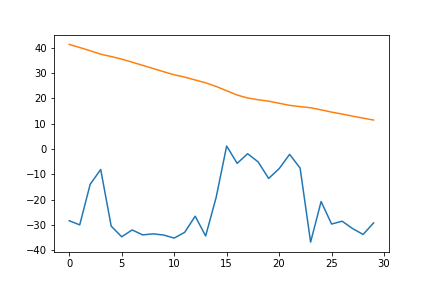

In [78]:
plt.close('all')
plt.plot(range(30), ceres_dome_c.sfc_net_lw_all_daily)
plt.plot(range(30), ceres_dome_c.sfc_net_sw_all_daily)
plt.show()